In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dynamic_hedging_sims import SimulateStrat
import seaborn as sns

# Dynamic Hedging

The purpose is to demonstrate how our dynamic hedging strategy works. <br>
We'll review the logic behind the strategy, how the strategy reacts given different conditions and simulate how the strategy would perform.

## How it Works

### Concept

The high-level concept is to generate returns via providing liquidity to AMMs, while hedging volatility risk. <br> 
The strategy uses lending protocols and AMMs. <br> 
The simplest form of the strategy uses a stablecoin and a volatile token. <br>
For simplicity we will use USDC as FTM and the sample tokens throughout this document, and we will assume we only provide liquidity to uniswapV2 style 50/50 pools. 

In simple terms, the strategy does the following: 
- Lend USDC
- Borrow FTM
- Provide liquidity to AMM

This is a very common strategy in DeFi. There are a number of protocols who offer delta-neutral vaults that borrow and provide liquidity using the borrowed funds. Most of these strategies rebalance positions using a paramater called 'Collateral Ratio'.<br>
Delta-neutral vaults work very well during ranging conditions. But when price has volatile movements in either direction, impermanent loss outweights the benefits and the strategy usually ends up unprofitable. 

For this reason, our strategy is designed with the flexibility of having long or short price exposure. We can think of delta-neutral as the "base" state of our strategy, and this state can be updated to have price exposure.

A good way to think about this is as a way of trading and (passively) market making at the same time.

### Strategy State and Math

The strategy consists of 3 different positions:
- The collateral lend (USDC)
- The debt borrow (FTM)
- The lp position (USDC-FTM)

The total value of the strategy is calculated as: <br>
> $ T = C - D + L $

> Where:
> - T: total value
> - C: collateral
> - D: debt
> - L: lp

#### Strategy Paramaters

As stated above, the strategy is design with flexibility in mind to allow a non-delta neutral state. <br>
This is acheived by adding a second parameter called 'Price Exposure'.

The strategy has 2 main user defined parameters:
- $ TCR $  (Target Collateral Ratio): ratio of the debt over collateral
- $ TE $  (Target Price Exposure): percentage of the total amount held in the strategy that has exposure to volatility 
> note: negative TE means short exposure.

Both parameters above are used to determine the target (or want) state the strategy aims to be at. <br>
At any moment in time, we can calculate the actual collateral ratio and price exposure of the strategy.
- Collateral ratio: $ CR=\frac{D}{C} $
- Price exposure: $ E=\frac{0.5*L-D}{T} $

#### Calculating the Want State

Assume we have $10000 of capital to invest (T = 10000) and we set TCR = 0.65 and TE = 0.
To get the want state, we have to solve the system of equations below.


$$
T=C-D+L\\
TCR=\frac{D}{C}\\
TE=\frac{0.5*L-D}{T}\\	
$$

Since we have the values of T, TCR and TE. We can get the values of C, D and L.

$$
C=\frac{T*(1-2*TE)}{1+TCR}\\
D=C*TCR\\
L=T-C+D\\	
$$

In [2]:
def want_state(t: float, tcr: float, te: float):
    c = t*(1 - 2*te)/(1 + tcr)
    d = c*tcr
    l = t - c + d
    return c, d, l

t = 10000
tcr = 0.65

# Example 1
c, d, l = want_state(t, tcr, 0)
print('TCR = 0.65 , TE = 0\n------------------')
print('Collateral: ${0:.2f}\nDebt: ${1:.2f}\nLP: ${2:.2f}\nTotal: ${3:.2f}'.format(c,d,l,c-d+l))

# Example 2
c, d, l = want_state(t, tcr, -0.1)
print('\n')
print('TCR = 0.65 , TE = -0.1\n------------------')
print('Collateral: ${0:.2f}\nDebt: ${1:.2f}\nLP: ${2:.2f}\nTotal: ${3:.2f}'.format(c,d,l,c-d+l))

TCR = 0.65 , TE = 0
------------------
Collateral: $6060.61
Debt: $3939.39
LP: $7878.79
Total: $10000.00


TCR = 0.65 , TE = -0.1
------------------
Collateral: $7272.73
Debt: $4727.27
LP: $7454.55
Total: $10000.00


#### Evolution of Individual Positions

Since the strategy holds 2 tokens (USDC and FTM), the value of the strategy will depend on the price of them. Since USDC is a stablecoin, for the sake of simplicity, we will assume its value will stay constant. This means that the value of the strategy depends on the price evolution of FTM as well as the interest rates of each position.

Below, we show how the value of each position changes.

> Where: 
> - $i_c$ : lending interest rate
> - $i_d$ : debt interest rate
> - $i_l$ : lp interest via fees and farm rewards
> - $\Delta P$ : price change in percentage terms

$$
C_{i+1}=C_i*(1+i_c)\\
D_{i+1}=D_i*(1+i_d)*(1+\Delta P)\\
L_{i+1}=L_i*(1+i_l)*(1+\Delta P)^{0.5}*1^{0.5}\\	
$$


In [3]:
# Update collateral
def update_collateral(c: float, r: float):
    return c*(1+r)

# Update debt
def update_debt(d: float, p_chg: float, r: float):
    return d*(1+p_chg)*(1+r)

# Update lp
def update_lp(l: float, p1_chg: float, r: float):
    return l*(1+r)*((1+p1_chg)**0.5)*(1**0.5)

# Assume we start with state
t = 10000
tcr = 0.65
c, d, l = want_state(t, tcr, 0)

# Given the price change below, the positions now have
    # Also note that we are assuming the change occurs in a 1-month timeframe (this applicable to interest rates)
p_chg = 0.05
c1 = update_collateral(c, 0.01/12)
d1 = update_debt(d, p_chg, 0.03/12)
l1 = update_lp(l, p_chg, 0.25/12)
t1 = c1-d1+l1
print('Price Change = 5% , TE = 0\n------------------')
print('Collateral: ${0:.2f}\nDebt: ${1:.2f}\nLP: ${2:.2f}\nTotal: ${3:.2f}'.format(c1,d1,l1,t1))
print('Return: {0:.3f}%'.format(100*(t1/t-1)))

# Assume we start with state
t = 10000
tcr = 0.65
c, d, l = want_state(t, tcr, 0.1)

# Given the price change below, the positions now have
p_chg = 0.02
c1 = update_collateral(c, 0.01/12)
d1 = update_debt(d, p_chg, 0.03/12)
l1 = update_lp(l, p_chg, 0.25/12)
t1 = c1-d1+l1
print('\n')
print('Price Change = 2% , TE = 0.1\n------------------')
print('Collateral: ${0:.2f}\nDebt: ${1:.2f}\nLP: ${2:.2f}\nTotal: ${3:.2f}'.format(c1,d1,l1,t1))
print('Return: {0:.3f}%'.format(100*(t1/t-1)))

Price Change = 5% , TE = 0
------------------
Collateral: $6065.66
Debt: $4146.70
LP: $8241.55
Total: $10160.50
Return: 1.605%


Price Change = 2% , TE = 0.1
------------------
Collateral: $4852.53
Debt: $3222.58
LP: $8560.35
Total: $10190.29
Return: 1.903%


### Rebalancing

As price changes, the state of our strategy changes as well. In simple terms, as price moves further away from the initial investment price, the collateral ratio and price exposure move further away from the targets defined.

In the example below we show how the CR and E change.

In [4]:
# Define a function to update all positions at the same time
def update_all(c: float, d: float, l:float, rc: float, rd: float, rl: float, p_chg: float):
    _c = update_collateral(c, rc)
    _d = update_debt(d, p_chg, rd)
    _l = update_lp(l, p_chg, rl)
    return _c, _d, _l

# Define a function to calculate the current state
def get_state(c: float, d: float, l: float):
    _cr = d/c
    _e = (l*0.5 - d)/(c-d+l)
    return _cr, _e

# Given the initial state, we can see that the state is the same as our target
c, d, l = want_state(10000, 0.65, 0)
cr, e = get_state(c, d, l)
print('Initial State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}'.format(cr, e))

# Now given a 5% price change
rc, rd, rl, p_chg = 0.01/12, 0.03/12, 0.25/12, 0.05
c1, d1, l1 = update_all(c, d, l, rc, rd, rl, p_chg)
cr, e = get_state(c1, d1, l1)
print('\n')
print('New State with 5% Price Change and TE = 0\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}'.format(cr, e))

# This is even more visible with higher target exposure and price changes
c, d, l = want_state(10000, 0.65, -0.1)
cr, e = get_state(c, d, l)
print('\n')
print('Initial State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}'.format(cr, e))
rc, rd, rl, p_chg = 0.01/12, 0.03/12, 0.25/12, -0.2
c1, d1, l1 = update_all(c, d, l, rc, rd, rl, p_chg)
cr, e = get_state(c1, d1, l1)
print('\n')
print('New State with -20% Price Change and TE = -0.1\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}'.format(cr, e))

Initial State
---------------
CR: 0.650
E: -0.000


New State with 5% Price Change and TE = 0
---------------
CR: 0.684
E: -0.003


Initial State
---------------
CR: 0.650
E: -0.100


New State with -20% Price Change and TE = -0.1
---------------
CR: 0.521
E: -0.038


In order to tackle this, we have to rebalance our positions periodically when specific conditions are met. <br>
We have 2 types of rebalancing operations:
- Collateral rebalance: modifies collateral and debt to bring collateral ratio back to its target value
- Exposure rebalance: modifies debt and lp to bring the exposure back to its target value

#### Collateral Ratio Rebalancing

The first step is to define thresholds for when rebalancing should be executed. <br>
If the collateral ratio of the strategy moves outside either of the thresholds we will rebalance it. <br>
For this, we will define 2 more parameters:
- Max CR: maximum collateral ratio allowed
- Min CR: minimum collateral ratio allowed
> note: the Max CR is the most important parameter here. Since this is also used to ensure that our short position is not liquidated.

There are many ways to perform this operation. Ideally we want to avoid swapping assets. Since our liquidity pool consists of a 50/50 split, we will rebalance by adding/removing the same amount from our collateral and debt positions.

In other words, given the current collateral value is $C_i$, debt value $D_i$ and lp value $L_i$. We want to solve the equation below.
> Where:
> - $a$: is the amount to add to our collateral position and to repay our debt

$$
TCR = \frac{D_i-a}{C_i+a} \Rightarrow a=\frac{D_i-C_i*TCR}{1+TCR}
$$

First, note that if $a$ is negative, it means that we need to remove collateral and borrow FTM. If $a$ is positive, then we need to add collateral and repay our debt. <br>
If $a$ is positive, we need to remove assets from the liquidity pool so we can add collateral and repay. In fact, we need to remove $2*a$. <br>
Hence, we need to update our state in the following manner:

$$
C_{i+1}=C_i+a\\
D_{i+1}=D_i-a\\
L_{i+1}=L_i-2*a\\	
$$

In [5]:
# Collateral rebalance
def cr_rebal(c: float, d: float, l: float, tcr: float):
    _a = (d-c*tcr)/(1+tcr)
    _c = c + _a
    _d = d - _a
    _l = l - 2*_a
    return _a, _c, _d, _l

# Given the initial state
c, d, l = want_state(10000, 0.65, 0)
cr, e = get_state(c, d, l)
print('Initial State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}'.format(cr, e, c-d+l))

# Now given a price change
rc, rd, rl, p_chg = 0.01/12, 0.03/12, 0.25/12, 0.1
c1, d1, l1 = update_all(c, d, l, rc, rd, rl, p_chg)
cr, e = get_state(c1, d1, l1)
print('\n')
print('New State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}'.format(cr, e, c1-d1+l1))

# Now, if we rebalance collateral ratio we get
a, c2, d2, l2 = cr_rebal(c1, d1, l1, 0.65)
cr, e = get_state(c2, d2, l2)
print('\n')
print('Updated State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}\na: ${3:.2f}'.format(cr, e, c2-d2+l2, a))

Initial State
---------------
CR: 0.650
E: -0.000
Total: $10000.00


New State
---------------
CR: 0.716
E: -0.012
Total: $10156.99


Updated State
---------------
CR: 0.650
E: -0.012
Total: $10156.99
a: $243.33


As we can see above, the collateral ratio of the strategy is back to our target value. <br>
Also, note that the total value remains the same and that the exposure doesn't change. <br>
This makes sense, since we are removing $2*a$ from the liquidity pool and removing $a$ from our debt position. <br>
Looking at our exposure equation we can see that this operation has no impact to it.

$$
E=\frac{0.5*L-D}{T} \Rightarrow E=\frac{0.5*(L-2*a)-(D-a)}{T} \Rightarrow E=\frac{0.5*L-a-D+a}{T} \Rightarrow E=\frac{0.5*L-D}{T}
$$

#### Exposure Rebalancing

Since our collateral rebalancing operation doesn't affect exposure, we need to create another operation. <br>
As before, we will define a threshold which represents boundaries that will trigger a rebalancing operation. <br>
In this case we will define only 1 parameter:
- E Treshold: the max absolute value allowed for the difference between the target and current exposure.

In this operation is not possible to avoid swapping assets. Hence, we have to account for trading fees as part of the operation. <br>

Given the current collateral value is $C_i$, debt value $D_i$ and lp value $L_i$. We want to solve the equation below.
> Where:
> - $a$: is the amount to remove from the lp and repay
> - $swapfee$: is the trading fee that the strategy will incur

$$
TE=\frac{0.5*(L_i-a)-(D_i-a)}{T_i} \Rightarrow a=2*(TE*T_i-0.5*L_i+D_i)
$$

Note that a positive $a$ means we remove from the lp and repay. A negative $a$ means we borrow and add to the lp. <br>
Hence, the new state should be updated in the following manner:

If $a > 0$ Then

$$
C_{i+1}=C_i\\
D_{i+1}=D_i-0.5*a*(2-swapfee)\\
L_{i+1}=L_i-a\\	
$$

If $a < 0$ Then

$$
C_{i+1}=C_i\\
D_{i+1}=D_i-a\\
L_{i+1}=L_i-0.5*a*(2-swapfee)\\	
$$

Note that depending on the sign of $a$ we charge swapfee either to the lp of debt. Also, note that we only charge the swapfee to 50% of the value of a. This is because we always need to swap 50% of $a$.

In [6]:
# Exposure rebalance
def exposure_rebal(c:float, d: float, l:float, te: float, swapfee: float=0.0025):
    t = c-d+l
    _a = 2*(te*t - 0.5*l + d)
    if _a > 0:
        _c = c
        _d = d - 0.5*_a*(2-swapfee)
        _l = l - _a
    elif _a <= 0:
        _c = c
        _d = d - _a
        _l = l - 0.5*_a*(2-swapfee)   
    return _a, _c, _d, _l

# Given the initial state
c, d, l = want_state(10000, 0.65, 0)
cr, e = get_state(c, d, l)
print('Initial State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}'.format(cr, e, c-d+l))

# Now given a price change
rc, rd, rl, p_chg = 0.01/12, 0.03/12, 0.25/12, 0.1
c1, d1, l1 = update_all(c, d, l, rc, rd, rl, p_chg)
cr, e = get_state(c1, d1, l1)
print('\n')
print('New State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}'.format(cr, e, c1-d1+l1))

# Now, if we rebalance collateral ratio we get
a, c2, d2, l2 =  exposure_rebal(c1, d1, l1, 0)
cr, e = get_state(c2, d2, l2)
print('\n')
print('Updated State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}\na: ${3:.2f}'.format(cr, e, c2-d2+l2, a))

Initial State
---------------
CR: 0.650
E: -0.000
Total: $10000.00


New State
---------------
CR: 0.716
E: -0.012
Total: $10156.99


Updated State
---------------
CR: 0.675
E: -0.000
Total: $10156.67
a: $252.84


Note that eventhough the exposure has come back to our target value, the collateral ratio of the strategy also changed. 
This makes perfect sense when thinking about the collateral ratio equation. In our example, since $a$ is positive, we remove from the lp and repay debt. Hence, reducing the collateral ratio.<br>
Also, note the reduction in the total value held by the strategy due to trading fees.

$$
CR = \frac{D_i-a}{C_i}
$$

## Simulation Overview

In this section we will present a high-level review of how the strategy performs using FTM price action.

### FTM Chart

We will simulate how the strategy performs given different parameters. <br>
The dataset will be FTM hourly price action from 06-01-2022 to 03-31-2023.

Key points
- The dataset has a good amount of volatility with price doing multiple 50% drops and a >300% increase
- There is a period of low volatility range
- A period where price rallied significantly
- Multiple periods where price decrease by 50%

FTM max price: $0.649
FTM min price: $0.165
FTM avg price: $0.306


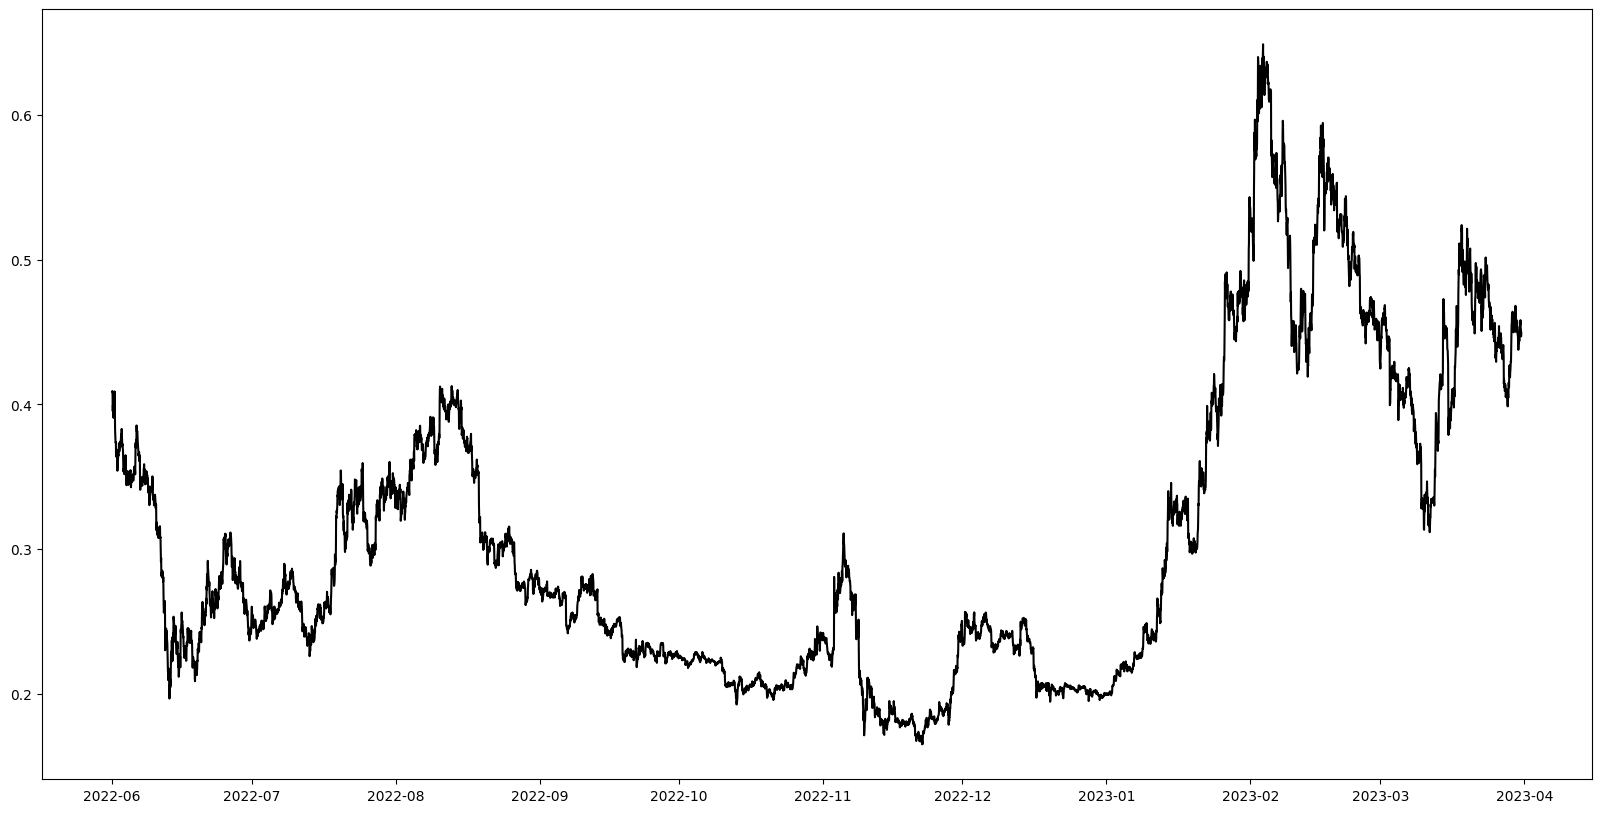

In [7]:
# Load data
data = pd.read_csv('ftm_1hr.csv')
data['time'] = pd.to_datetime(data['time'])

# Summary stats
print('FTM max price: ${:.3f}'.format(data['close'].max()))
print('FTM min price: ${:.3f}'.format(data['close'].min()))
print('FTM avg price: ${:.3f}'.format(data['close'].mean()))

# Plot data
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.plot(data['time'], data['close'], color = 'black')
plt.show()

### Simulations

The purpose here is to get a high-level understanding of how the strategy performs given different target exposures and exposure thresholds. <br>
We will start by defining the parameters that will remain constant in all simulations.
- Set the lending rates to 1% and the borrow rate to 3% apr
- Assume the AMM apr is 25%
- Set 60 minutes per step since we are using the hourly dataset

We also want to do a quick review of how the rebalancing logic works.
- During every step, we first check if exposure needs to be rebalanced
    - absolute value of current exposure minus target exposure is greater than the exposure threshold defined
    - $|E - TE| > ethresh$
- we then check if the collateral ratio needs to be rebalanced
    - current collateral ratio > max collateral ratio or current collateral ratio < min collateral ratio
    - $CR > CR_{MAX}$  or  $CR < CR_{MIN}$
    
Note that we first rebalance exposure because this operations changes the collateral ratio, while the collateral rebalance operation doesn't change the exposure.

In [8]:
t = 100
tcr = 0.65
c_apr = 0.01
d_apr = 0.03
l_apr = 0.25
min_per_step = 60
pricefeed = data['close'].tolist()
min_cr = 0.45
max_cr = 0.7

#### Sim 1

Our first example is a delta-neutral strategy where we rebalance exposure if it has a difference greater than 5% from our target.

Notes:
- The strategy performs relatively well with a total return of 6.5%
- It has a max daily drawdown of 0.84% and a max weekly drawdown of 1.43%
- Collateral is rebalanced 33 times and exposure only 9 times

In [9]:
te = 0
e_thresh = 0.05
sim = SimulateStrat(t, tcr, te)

# Run simulation
sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr)

# Sim results
sim.print_sim_stats()


----------------------Strategy Total----------------------
Strategy Initial: $100.00
Strategy Final: $106.56
Strategy Max: $106.57
Strategy Min: $98.65

--------------------Strategy Timeframe--------------------
Total time in days: 303.2916666666667

--------------------Strategy Returns--------------------
Return: 6.562%
Total Return: $6.56235
Annualized Return: 7.898%
Max Daily Return: 0.454%
Min Daily Return: -0.840%
Max Weekly Return: 0.858%
Min Weekly Return: -1.432%

---------------------Strategy Params----------------------
Max Collateral Ratio: 0.73
Max Exposure: 0.05
Min Collateral Ratio: 0.44
Min Exposure: -0.05

---------------------Strategy Actions----------------------
Count of Collateral Rebalance: 33
Count of Exposure Rebalance: 9
Count of Both Rebalance: 3
Count of Exposure Update: 0


The plot below shows how the strategy changes in values through time. <br>
Also, note how each position ranges between with sharp changes which occur during rebalancing operations.

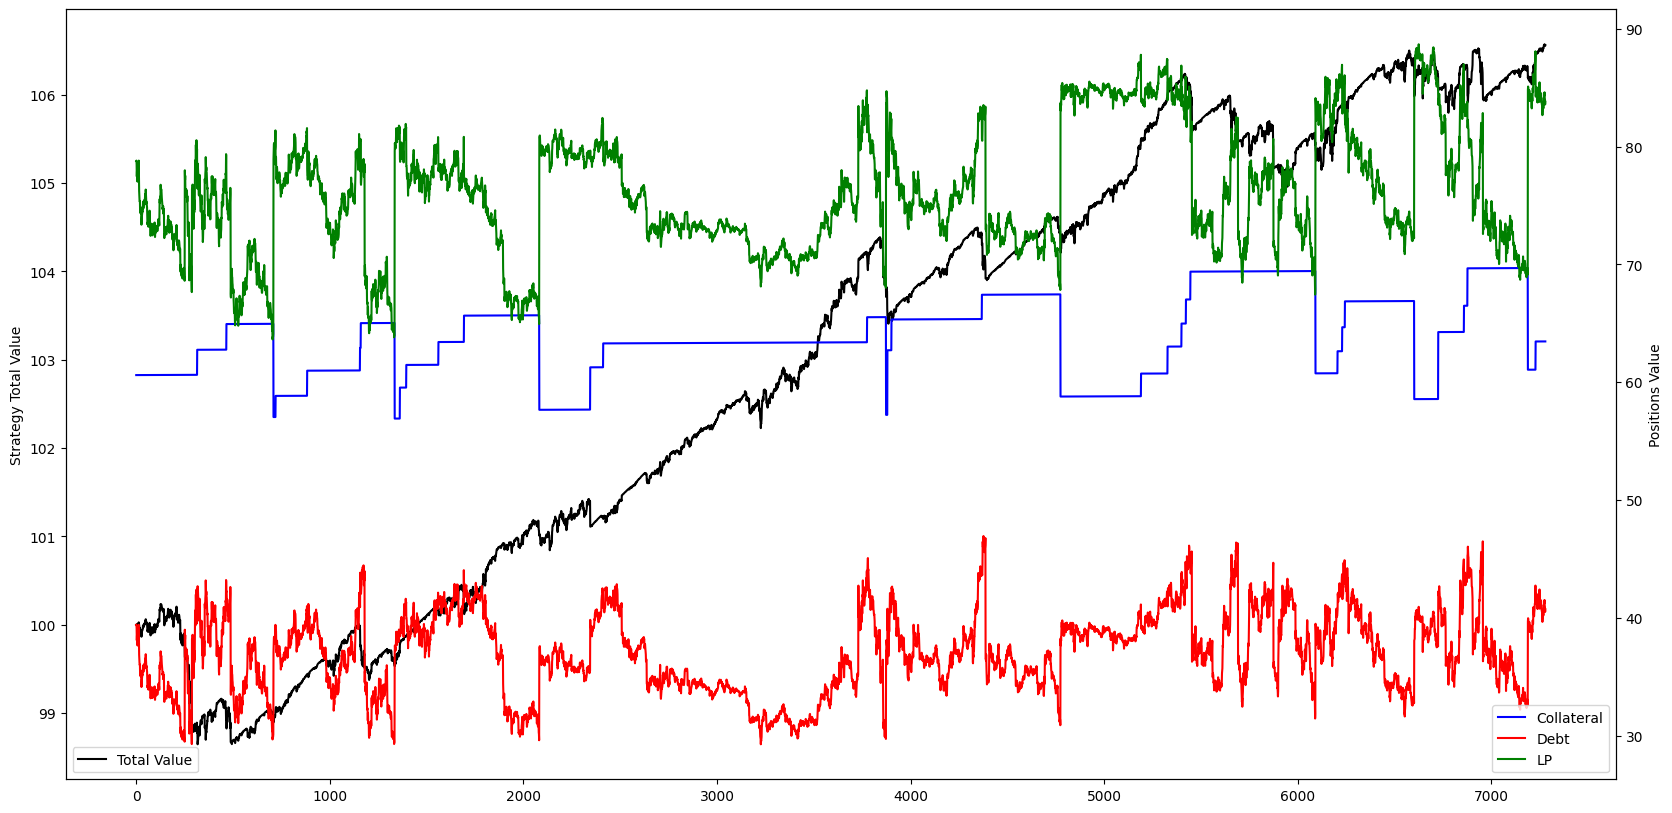

In [10]:
sim.plot_totals(True)

The chart below shows the strategy value and the FTM price. <br>
Rebalancing operations are also shown.

The main point here is that rebalancing operations occur during periods of volatility. Note that during the long period of low volatiltiy there were practically no rebalancing operations and the strategy generated consistent returns. <br>
It's also curious to note that exposure rebalancing operations tend to mark local bottoms on the strategy performance.

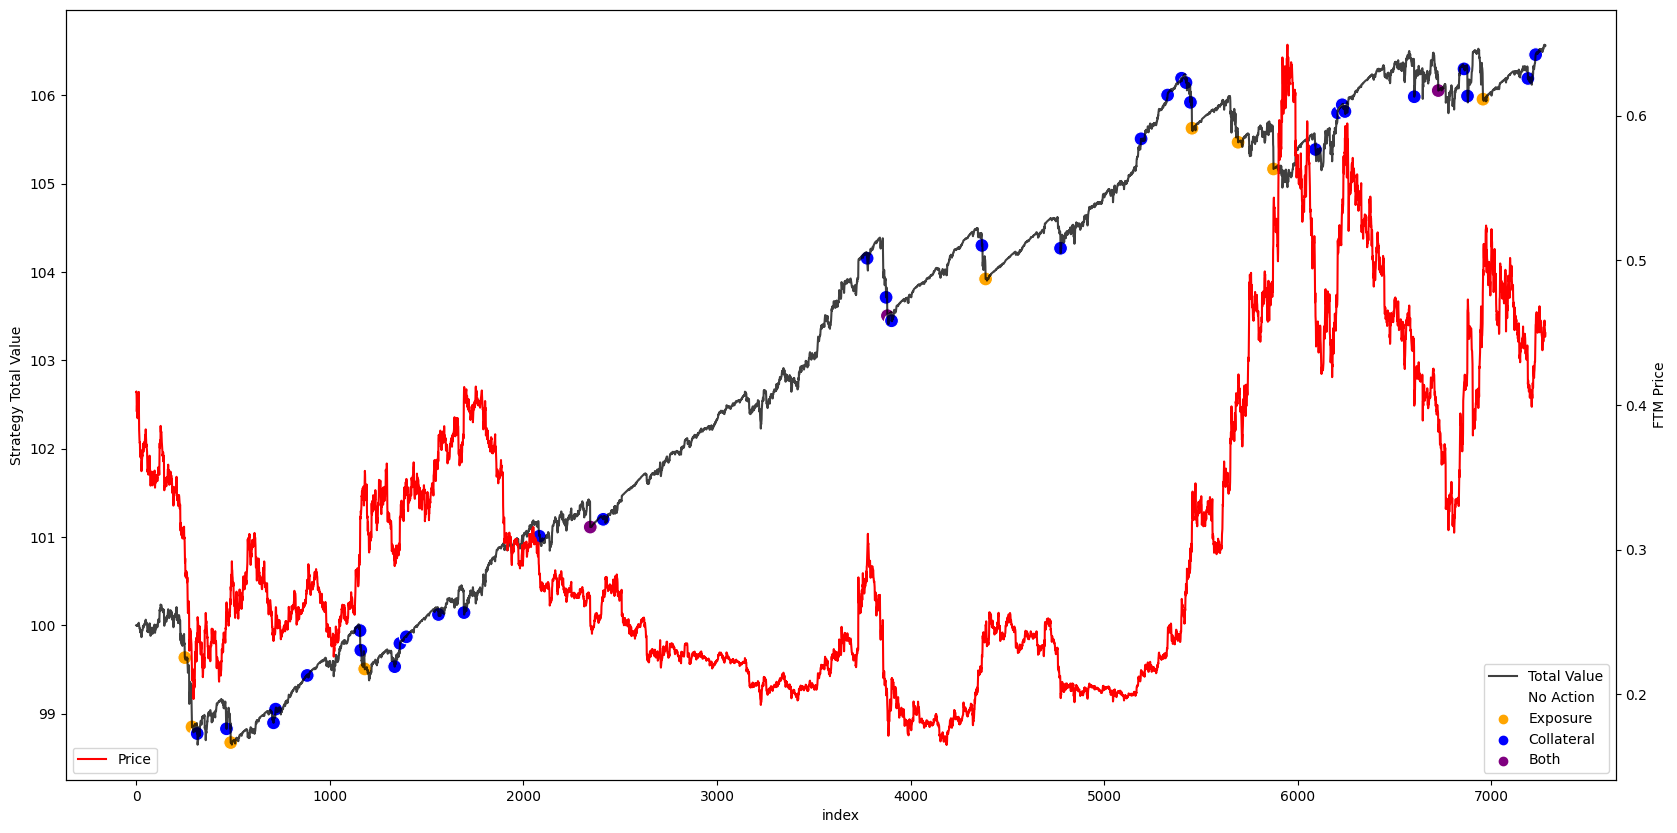

In [11]:
sim.plot_totals_with_rebalance_points()

The chart below is mostly for reference and to demonstrate how the collateral ratio and exposure react during the evolution of the strategy.

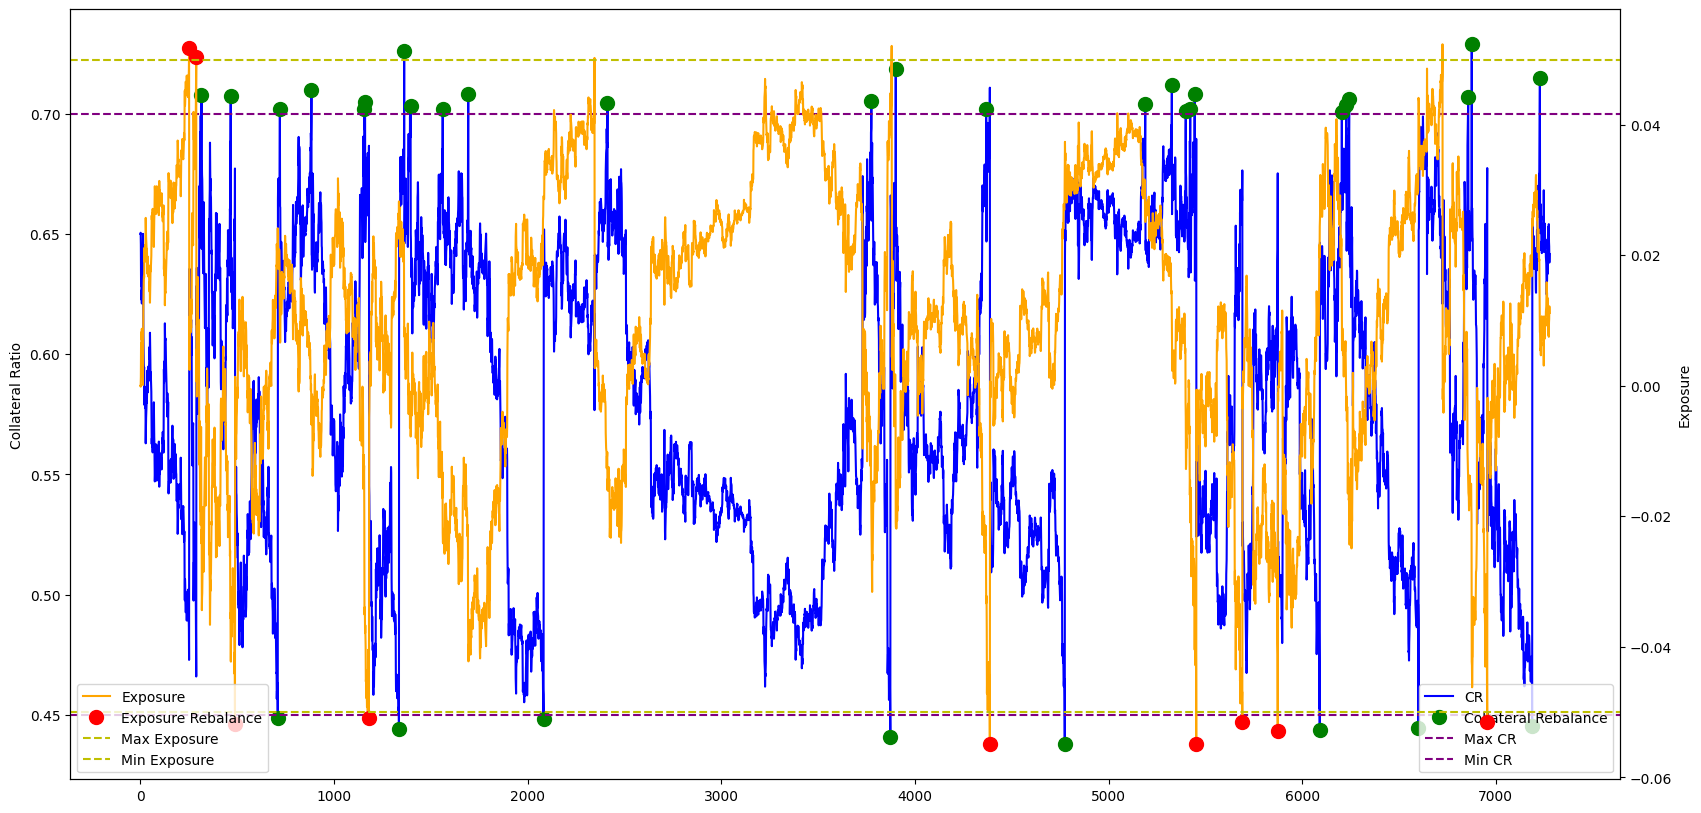

In [12]:
sim.plot_cr_exposure()

#### Sim 2

Our second example has a 10% long exposure and has a tighter exposure rebalancing range of 2.5%.

Notes:
- Even though the stratey is profitable, there is significant more volatility to its returns. This can be seen in the daily and weekly max and min returns
- Note that with a tighter exposure rebalancing range, we rebalance exposure more frequently than collateral

In [13]:
te = 0.1
e_thresh = 0.025
sim = SimulateStrat(t, tcr, te)

# Run simulation
sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr)

# Sim results
sim.print_sim_stats()


----------------------Strategy Total----------------------
Strategy Initial: $100.00
Strategy Final: $109.03
Strategy Max: $112.31
Strategy Min: $92.65

--------------------Strategy Timeframe--------------------
Total time in days: 303.2916666666667

--------------------Strategy Returns--------------------
Return: 9.028%
Total Return: $9.02818
Annualized Return: 10.865%
Max Daily Return: 2.485%
Min Daily Return: -3.282%
Max Weekly Return: 4.938%
Min Weekly Return: -6.935%

---------------------Strategy Params----------------------
Max Collateral Ratio: 0.73
Max Exposure: 0.13
Min Collateral Ratio: 0.41
Min Exposure: 0.07

---------------------Strategy Actions----------------------
Count of Collateral Rebalance: 11
Count of Exposure Rebalance: 23
Count of Both Rebalance: 2
Count of Exposure Update: 0


Note that with a relatively high long exposure (10%), the returns of the strategy become significantly more correlated to the price of FTM.

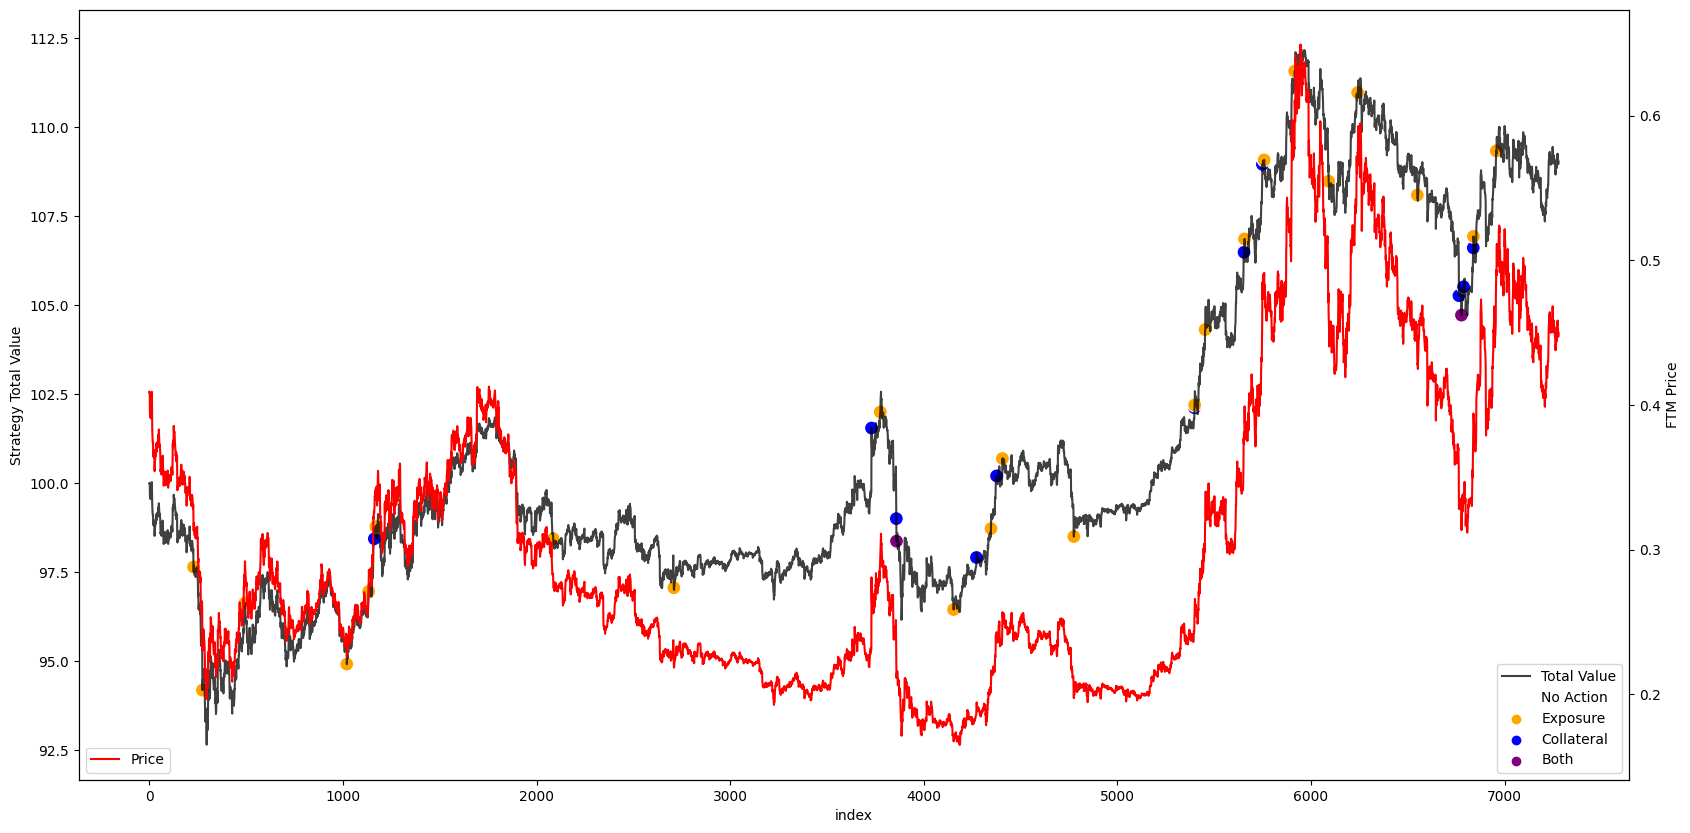

In [14]:
sim.plot_totals_with_rebalance_points()

#### Sim 3

Our third example has a -5% short exposure and has a exposure rebalancing range of 10%.

Notes:
- Even though the strategy has a negative performance, which makes sense given FTM price increase (>300%), the max drawdown was from 102.97 to 92.03 which corresponds to approx. a 10.5% drawdown.
- Also note that with a 10% exposure rebalance threshold, we dont have a single exposure rebalancing operation, and 8 cases where we rebalance both

In [15]:
te = -0.05
e_thresh = 0.1
sim = SimulateStrat(t, tcr, te)

# Run simulation
sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr)

# Sim results
sim.print_sim_stats()


----------------------Strategy Total----------------------
Strategy Initial: $100.00
Strategy Final: $96.90
Strategy Max: $102.97
Strategy Min: $92.03

--------------------Strategy Timeframe--------------------
Total time in days: 303.2916666666667

--------------------Strategy Returns--------------------
Return: -3.099%
Total Return: $-3.09878
Annualized Return: -3.729%
Max Daily Return: 1.311%
Min Daily Return: -2.514%
Max Weekly Return: 2.834%
Min Weekly Return: -4.614%

---------------------Strategy Params----------------------
Max Collateral Ratio: 0.76
Max Exposure: 0.05
Min Collateral Ratio: 0.44
Min Exposure: -0.16

---------------------Strategy Actions----------------------
Count of Collateral Rebalance: 33
Count of Exposure Rebalance: 0
Count of Both Rebalance: 8
Count of Exposure Update: 0


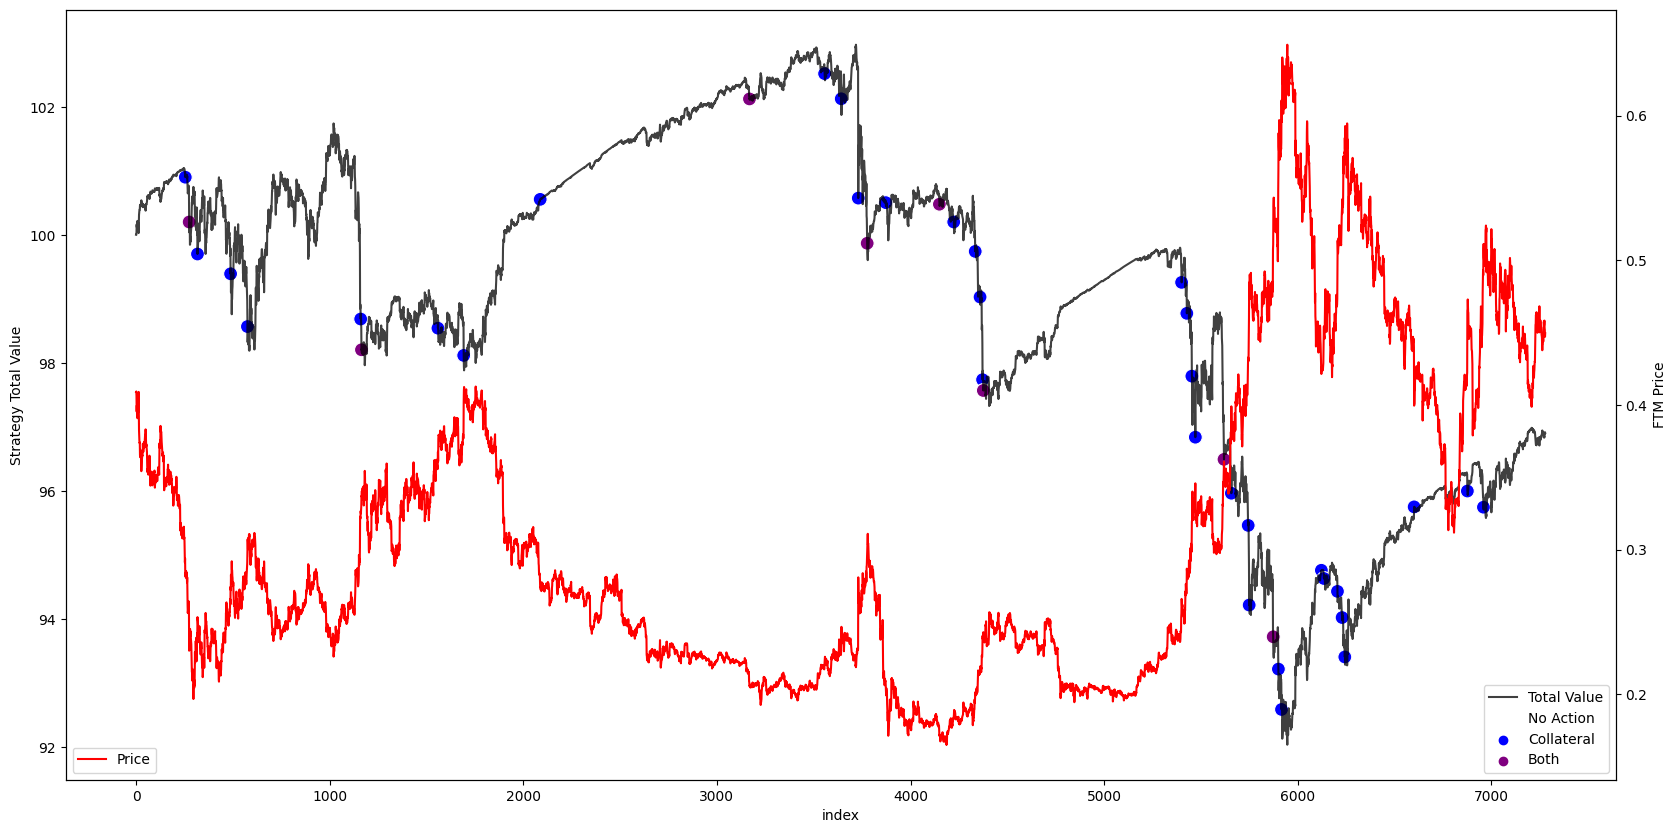

In [16]:
sim.plot_totals_with_rebalance_points()

## Detailed Analysis

Now, that we have defined how the strategy works and given a sense of how the strategy performs given different parameters, we will perform a detailed analysis on our strategy. 

### Paramaters and Price Analisys

We will now analyze how the strategy reacts during different price scenarios given different parameters.

NOTE: returns in this analysis will have a negative bias. This is due to the low number of data points we have in the pricefeeds below and the fact we are using 1-hour steps. In other words, AMM trading fees and farming returns are neglible since the amount of time simulating the strategies is less than 1-day.

#### Pricefeeds Review

We start by plotting the different pricefeeds. <br>
The pricefeeds can be divided into 4 buckets:
- Up
- Down
- Range
- Concave

In [17]:
feeds = pd.read_csv('price_datasets.csv')
for c in feeds.columns:
    total = 100*(feeds[c].values[-1]-feeds[c].values[0])/feeds[c].values[0]
    max_return = 100*(feeds[c].max()-feeds[c].values[0])/feeds[c].values[0]
    max_drawdown = 100*(feeds[c].values[0]-feeds[c].min())/feeds[c].values[0]
    print('Feed: {}\n--------------'.format(c))
    print('Total Return: {0:.2f}% , Max Return: {1:.2f}% , Max Drawdown: -{2:.2f}%\n'.format(total,max_return,max_drawdown))

Feed: up
--------------
Total Return: 120.00% , Max Return: 120.00% , Max Drawdown: -0.00%

Feed: down
--------------
Total Return: -60.00% , Max Return: 0.00% , Max Drawdown: -60.00%

Feed: concave up
--------------
Total Return: 0.00% , Max Return: 0.00% , Max Drawdown: -35.48%

Feed: concave down
--------------
Total Return: 0.00% , Max Return: 57.89% , Max Drawdown: -0.00%

Feed: range
--------------
Total Return: 0.00% , Max Return: 50.00% , Max Drawdown: -50.00%

Feed: big range
--------------
Total Return: 0.00% , Max Return: 100.00% , Max Drawdown: -50.00%

Feed: tight range
--------------
Total Return: -5.00% , Max Return: 25.00% , Max Drawdown: -10.00%

Feed: up range
--------------
Total Return: 80.00% , Max Return: 80.00% , Max Drawdown: -0.00%

Feed: down range
--------------
Total Return: -45.00% , Max Return: 0.00% , Max Drawdown: -45.00%

Feed: big concave up
--------------
Total Return: 0.00% , Max Return: 0.00% , Max Drawdown: -54.55%

Feed: big concave down
---------

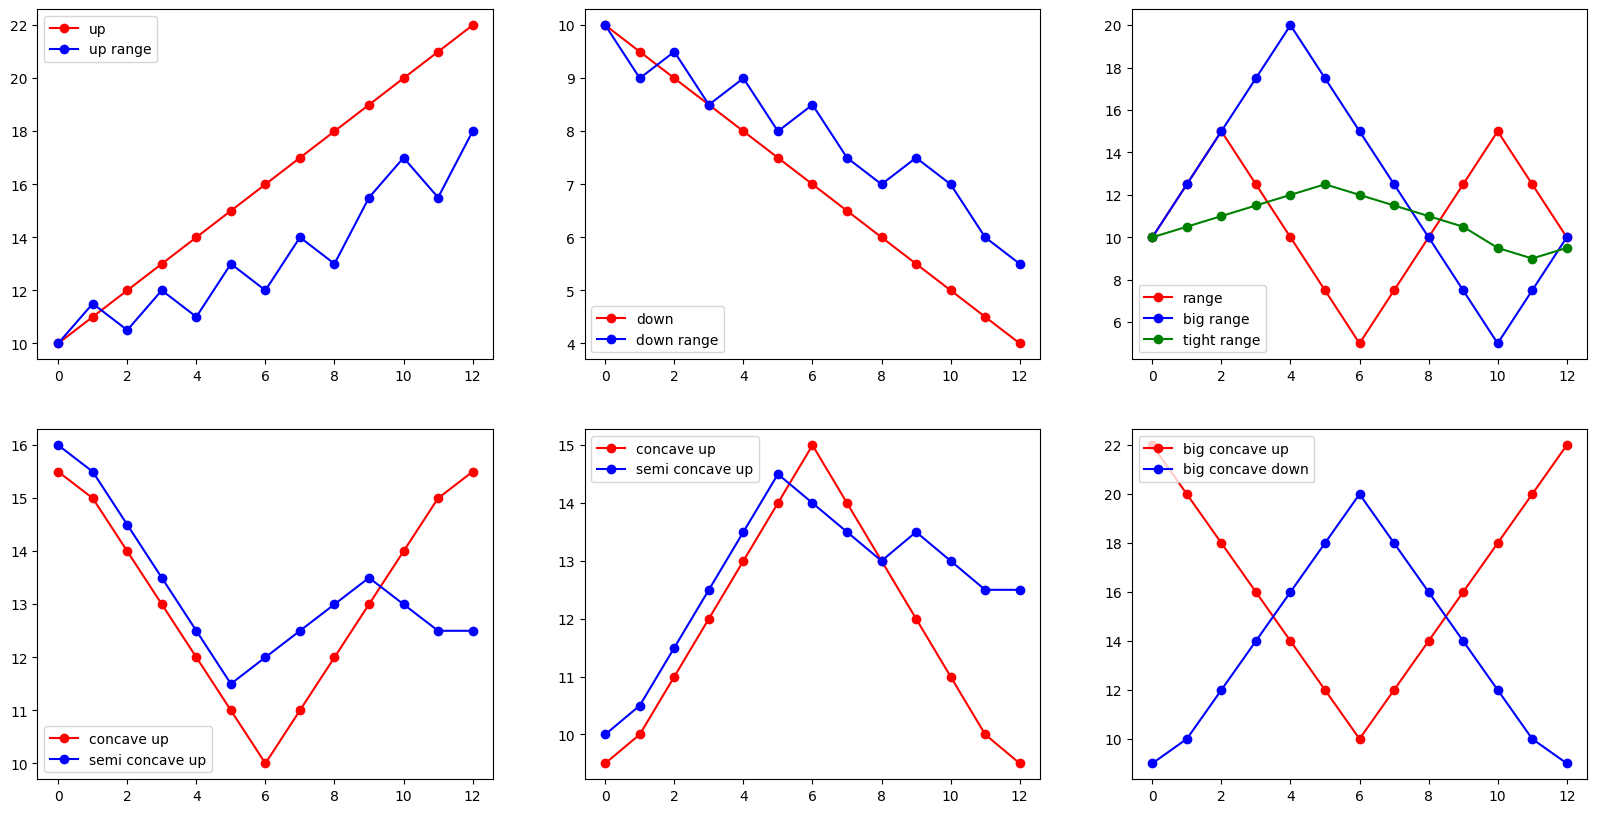

In [18]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20,10)
f_plt = feeds.copy()

ax[0,0].plot(f_plt['up'], marker='o',color='r', label='up')
ax[0,0].plot(f_plt['up range'], marker='o',color='b', label='up range')
ax[0,0].legend(loc='upper left')

ax[0,1].plot(f_plt['down'], marker='o',color='r', label='down')
ax[0,1].plot(f_plt['down range'], marker='o',color='b', label='down range')
ax[0,1].legend(loc='lower left')

ax[0,2].plot(f_plt['range'], marker='o',color='r', label='range')
ax[0,2].plot(f_plt['big range'], marker='o',color='b', label='big range')
ax[0,2].plot(f_plt['tight range'], marker='o',color='green', label='tight range')
ax[0,2].legend(loc='lower left')

ax[1,0].plot(f_plt['concave up'], marker='o',color='r', label='concave up')
ax[1,0].plot(f_plt['semi concave up'], marker='o',color='b', label='semi concave up')
ax[1,0].legend(loc='lower left')

ax[1,1].plot(f_plt['concave down'], marker='o',color='r', label='concave up')
ax[1,1].plot(f_plt['semi concave down'], marker='o',color='b', label='semi concave up')
ax[1,1].legend(loc='upper left')

ax[1,2].plot(f_plt['big concave up'], marker='o',color='r', label='big concave up')
ax[1,2].plot(f_plt['big concave down'], marker='o',color='b', label='big concave down')
ax[1,2].legend(loc='upper left')

plt.show()

#### Running Simulations and Gathering Data

Functions below are used to simulate the performance of the strategy using all parameters.
Strategies data will be stored in a dataframe for analisys.

In [19]:
# Define a function used to run multiple sims
def run_multiple_sims(sim: SimulateStrat, pricefeed: list[float], c_apr: float, d_apr: float, l_apr: float, min_per_step: float, 
                      max_cr_ls: list[float], e_thresh_ls: list[float], min_cr_ls: list[float], update_exposure: list[float]=[], 
                      names: list[float]=[]):
    t = sim.get_total()
    results = {}
    detailed_results = pd.DataFrame()
    
    # Loop through sim_params
    for i in range(0, len(max_cr_ls)):
        # reset sim
        sim.reset_strat(t)
        
        # run sim
        max_cr = max_cr_ls[i]
        e_thresh = e_thresh_ls[i]
        min_cr = min_cr_ls[i]
        sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr, update_exposure)
        
        # Get max drawdowns and max returns
        periods_per_day = 24*60/min_per_step
        sim.simdf['daily_return'] = sim.simdf['Total'].pct_change(int(periods_per_day))
        periods_per_week = 7*24*60/min_per_step
        sim.simdf['weekly_return'] = sim.simdf['Total'].pct_change(int(periods_per_week))
        
        # Save sim results
        k = 'max cr: {0} - e thresh: {1} - min cr: {2}'.format(max_cr, e_thresh, min_cr) if len(names)==0 else names[i]
        results[k] = {}
        results[k]['return'] = 100*(sim.t_feed[-1] - sim.t_feed[0])/sim.t_feed[0]
        results[k]['annualized_return'] = np.round(365*((sim.t_feed[-1] - sim.t_feed[0])/(sim.min_per_step*len(sim.pricefeed)/(60*24)))/sim.t_feed[0], 4)
        results[k]['max_cr'] = max(sim.cr_feed)
        results[k]['max_e'] = max(sim.e_feed)
        results[k]['min_cr'] = min(sim.cr_feed)
        results[k]['min_e'] = min(sim.e_feed)  
        results[k]['cr_rebal_count'] = sum([x == 'Collateral' for x in sim.action_feed])
        results[k]['exposure_rebal_count'] = sum([x == 'Exposure' for x in sim.action_feed])
        results[k]['both_rebal_count'] = sum([x == 'Both' for x in sim.action_feed])
        results[k]['exposure_update_count'] = sum([x == 'Updated Exposure' for x in sim.action_feed])
        results[k]['df'] = sim.simdf
        results[k]['params'] = {'max_cr':max_cr, 'e_thresh':e_thresh, 'min_cr':min_cr}
        results[k]['max_daily_return'] = sim.simdf['daily_return'].max()
        results[k]['min_daily_return'] = sim.simdf['daily_return'].min()
        results[k]['max_weekly_return'] = sim.simdf['weekly_return'].max()
        results[k]['min_weekly_return'] = sim.simdf['weekly_return'].min()
        t_feed = sim.simdf['Total']
        results[k]['max_return'] = 100*(t_feed.max()-t_feed.values[0])/t_feed.values[0]
        results[k]['max_drawdown'] = 100*(t_feed.min()-t_feed.values[0])/t_feed.values[0]
        
        # Save detailed sims results
        temp_df = sim.simdf[['Total','Price','Target Exposure',]].copy()
        temp_df.reset_index(inplace=True)
        temp_df.rename(columns={'Target Exposure':'te'}, inplace=True)
        temp_df['e_thresh'] = e_thresh
        temp_df['price_change'] = 100*((temp_df['Price']/temp_df['Price'].values[0])-1)
        temp_df['total_change'] = 100*((temp_df['Total']/temp_df['Total'].values[0])-1)
        detailed_results = pd.concat([detailed_results,temp_df])
        
    return results, detailed_results

In [20]:
# Define sim static params
t = 100
tcr = 0.65
c_apr = 0.01
d_apr = 0.02
l_apr = 0.25
min_per_step = 60
min_cr = 0.45
max_cr = 0.7

# Define hyperparams
e_thresh_ls = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4]
te_ls = [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]
min_cr_ls = [min_cr]*len(e_thresh_ls)
max_cr_ls = [max_cr]*len(e_thresh_ls)

# Loop through pricefeeds and exposure
sim_results = {}
sims_details = pd.DataFrame()
for f in feeds.columns:
    pricefeed = feeds[f].to_list()    
    for te in te_ls:
        sim = SimulateStrat(t, tcr, te)
        results, detailed_results = run_multiple_sims(sim, pricefeed, c_apr, d_apr, l_apr, min_per_step, 
                                                      max_cr_ls, e_thresh_ls, min_cr_ls)
        for k in results.keys():
            k1 = k+' - te: {0} - feed: {1}'.format(te, f)
            sim_results[k1] = results[k]
            sim_results[k1]['params']['te'] = te
            sim_results[k1]['params']['pricefeed'] = f
        
        detailed_results['pricefeed'] = f
        sims_details = pd.concat([sims_details, detailed_results])

# Create df to analyze sims high-level info
sim_ls = [{**v['params'], 'return': v['return'], 'annualized_return': v['annualized_return'], 
           'cr_rebal_count': v['cr_rebal_count'], 'exposure_rebal_count': v['exposure_rebal_count'],
           'both_rebal_count': v['both_rebal_count'], 'exposure_update_count': v['exposure_update_count'], 
           'max_daily_return': v['max_daily_return'], 'min_daily_return': v['min_daily_return'], 
           'max_weekly_return': v['max_weekly_return'], 'min_weekly_return': v['min_weekly_return'],
           'max_return': v['max_return'], 'max_drawdown': v['max_drawdown']} 
           for v in sim_results.values()]
df = pd.DataFrame(sim_ls)

#### Strategy Pricefeeds Analysis

Here is a TLDR of our findings
- e_thresh values have less impact when using large long target exposures
- during trending conditions (both bull and bear), is more beneficial to have lower e_thresh values
- during ranging conditions, larger e_thresh values perform better
- using e_thresh values greater than 0.1 means there will be minimal exposure rebalancing operations
- keeping target exposures b/w -0.05 and 0.05 greatly reduces returns volatility of the strategy, even with big moves

In [21]:
# Function to analyze target exposure in specific pricefeeds
def analyze_te(pricefeeds, df):
    # Print key data
    for p in pricefeeds:
        print('Pricefeed: {}\n'.format(p)+'----------------')
        d = df.loc[df['pricefeed']==p].reset_index()

        # Display returns for common set ups
        _r = df.loc[(df['te']==0) & (df['e_thresh']==0.1) & (df['pricefeed']==p), 'return'].values[0]
        print('Total Return for te: 0 and e_thresh 0.1 -> {:.4f}%'.format(_r))
        _r = df.loc[(df['te']==0.05) & (df['e_thresh']==0.05) & (df['pricefeed']==p), 'return'].values[0]
        print('Total Return for te: 0.05 and e_thresh 0.05 -> {:.4f}%'.format(_r))
        _r = df.loc[(df['te']==-0.05) & (df['e_thresh']==0.05) & (df['pricefeed']==p), 'return'].values[0]
        print('Total Return for te: -0.05 and e_thresh 0.05 -> {:.4f}%'.format(_r))
        
        # Get params for max and min total return  
        print('')
        _id = d['return'].idxmax()
        print('Max Return {:.4f}% -> te: {} , e thresh: {}'.format(d['return'].values[_id], d['te'].values[_id], 
                                                                   d['e_thresh'].values[_id]))
        _id = d['return'].idxmin()
        print('Min Return {:.4f}% -> te: {} , e thresh: {}'.format(d['return'].values[_id], d['te'].values[_id], 
                                                                   d['e_thresh'].values[_id]))

        # Display delta neutral stats
        print('\nDelta Neutral Returns\n')
        print(d.loc[d['te']==0,['e_thresh','return','exposure_rebal_count']].round(2))
        print('\n')

    # Plot strategy returns vs price
    print('Plot below shows the strategy returns throughout the pricefeed timeline')
    print('Pricefeed price action is also included (Blue line)')
    df_sims = sims_details.loc[sims_details['pricefeed'].isin(pricefeeds)]
    fg = sns.relplot(x='index', y='total_change', data=df_sims, kind='line', col='pricefeed', hue='te', 
                palette=sns.color_palette("icefire", as_cmap=True))

    for feed, ax in fg.axes_dict.items():  
        ax1 = ax.twinx()
        sns.lineplot(data=df_sims[(df_sims['pricefeed'] == feed)], x='index', y='price_change', color='blue', errorbar=None, ax=ax1)
        ax1.set_ylabel('')

    fg.fig.subplots_adjust(wspace=.1)
    sns.move_legend(fg, "lower center", bbox_to_anchor=(.5, 1), ncols=5)
    plt.show()
    
    df_highlvl = df.loc[df['pricefeed'].isin(pricefeeds)]
    # Plot strategies total return vs target exposure
    print('Plot below shows the total strategy returns vs target exposure')
    sns.relplot(x='te', y='return', data=df_highlvl, kind='scatter', col='pricefeed', hue='e_thresh', 
                palette=sns.color_palette("crest", as_cmap=True))
    plt.show()

    # Plot strategies total return vs e_thresh
    print('Plot below shows the total strategy returns vs exposure threshold')
    print('Blue band represents the range for all target exposures')
    sns.relplot(x='e_thresh', y='return', data=df_highlvl, kind='line', col='pricefeed')
    plt.show()

**Up Pricefeeds**

Key Points:
- Long exposures perform well and short exposures dont (no real surprise)
- We have a -20% to 20% performance range for a 80-120% price increase as long as target exposure is b/w -0.2 and 0.2
- Lower e_thresh values perform better, but as target exposure increases e_thresh impact decreases

Pricefeed: up
----------------
Total Return for te: 0 and e_thresh 0.1 -> -3.5282%
Total Return for te: 0.05 and e_thresh 0.05 -> 1.9282%
Total Return for te: -0.05 and e_thresh 0.05 -> -5.8136%

Max Return 21.3132% -> te: 0.25 , e thresh: 0.01
Min Return -26.6569% -> te: -0.25 , e thresh: 0.4

Delta Neutral Returns

    e_thresh  return  exposure_rebal_count
35      0.01   -0.62                    11
36      0.02   -1.28                     5
37      0.05   -2.11                     3
38      0.10   -3.53                     0
39      0.20   -6.12                     0
40      0.30   -7.99                     0
41      0.40   -7.99                     0


Pricefeed: up range
----------------
Total Return for te: 0 and e_thresh 0.1 -> -2.4714%
Total Return for te: 0.05 and e_thresh 0.05 -> 1.5013%
Total Return for te: -0.05 and e_thresh 0.05 -> -4.3763%

Max Return 15.5214% -> te: 0.25 , e thresh: 0.01
Min Return -21.5154% -> te: -0.25 , e thresh: 0.4

Delta Neutral Returns

    e_thre

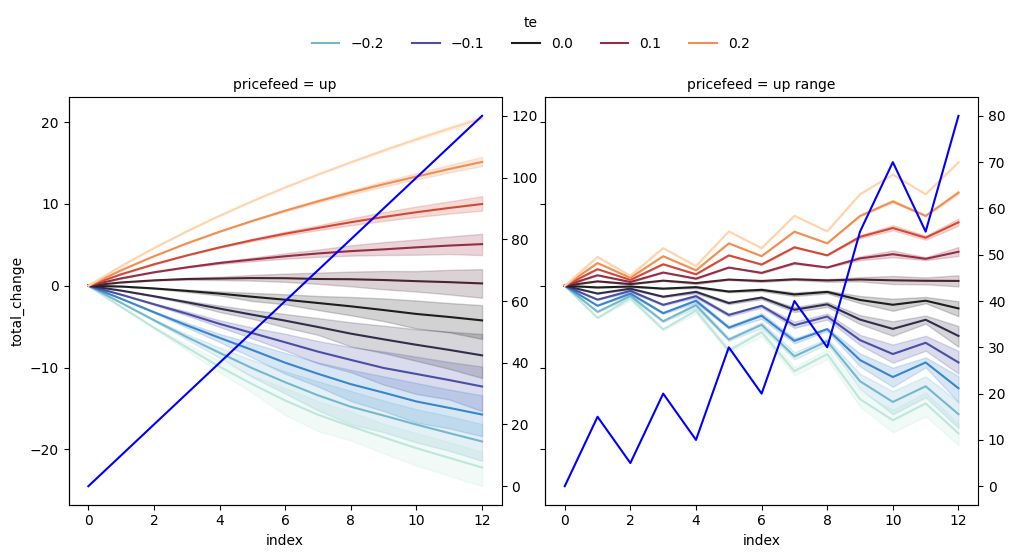

Plot below shows the total strategy returns vs target exposure


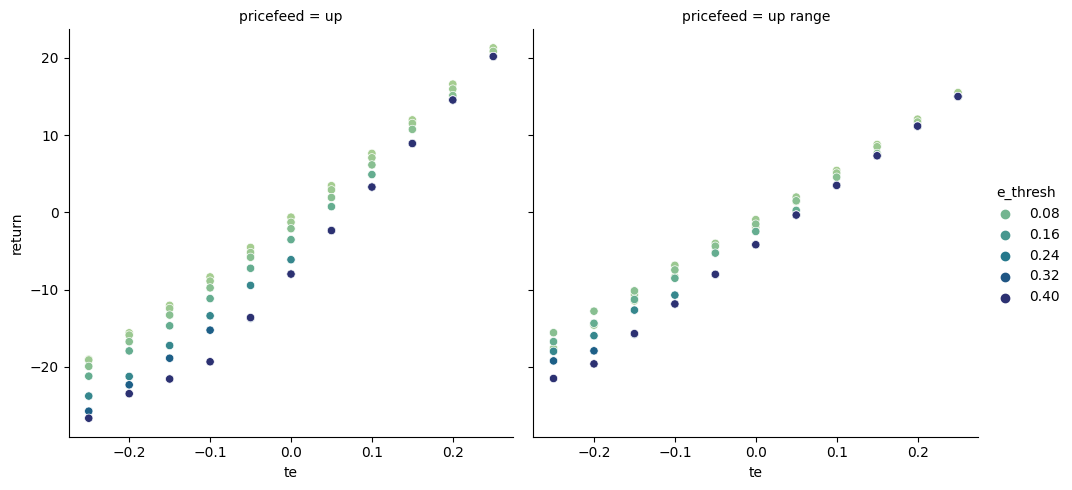

Plot below shows the total strategy returns vs exposure threshold
Blue band represents the range for all target exposures


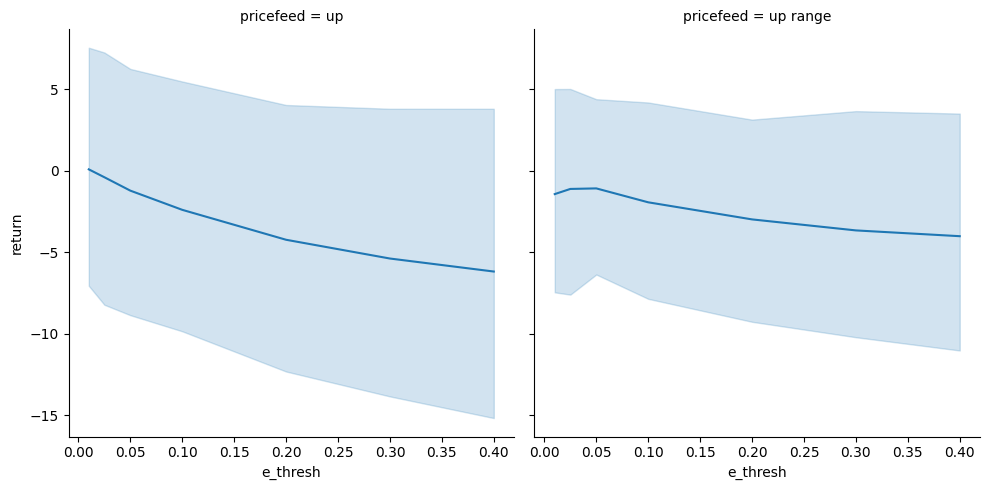

In [22]:
pricefeeds=['up','up range']
analyze_te(pricefeeds, df)

**Down Pricefeeds**

Key Points:
- Short exposures perform well and long exposures dont (no real surprise)
- We have a -20% to 20% performance range for a 50-60% price increase as long as target exposure is b/w -0.2 and 0.2
- Lower e_thresh values perform better, but as target exposure increases e_thresh impact decreases

Pricefeed: down
----------------
Total Return for te: 0 and e_thresh 0.1 -> -4.5852%
Total Return for te: 0.05 and e_thresh 0.05 -> -6.9421%
Total Return for te: -0.05 and e_thresh 0.05 -> 1.6829%

Max Return 23.7188% -> te: -0.25 , e thresh: 0.01
Min Return -21.2117% -> te: 0.25 , e thresh: 0.025

Delta Neutral Returns

    e_thresh  return  exposure_rebal_count
35      0.01   -0.69                    11
36      0.02   -1.45                     5
37      0.05   -2.35                     2
38      0.10   -4.59                     0
39      0.20   -5.69                     0
40      0.30   -5.69                     0
41      0.40   -5.69                     0


Pricefeed: down range
----------------
Total Return for te: 0 and e_thresh 0.1 -> -2.6265%
Total Return for te: 0.05 and e_thresh 0.05 -> -4.4877%
Total Return for te: -0.05 and e_thresh 0.05 -> 1.1482%

Max Return 13.6732% -> te: -0.25 , e thresh: 0.05
Min Return -14.2196% -> te: 0.25 , e thresh: 0.025

Delta Neutral Returns

  

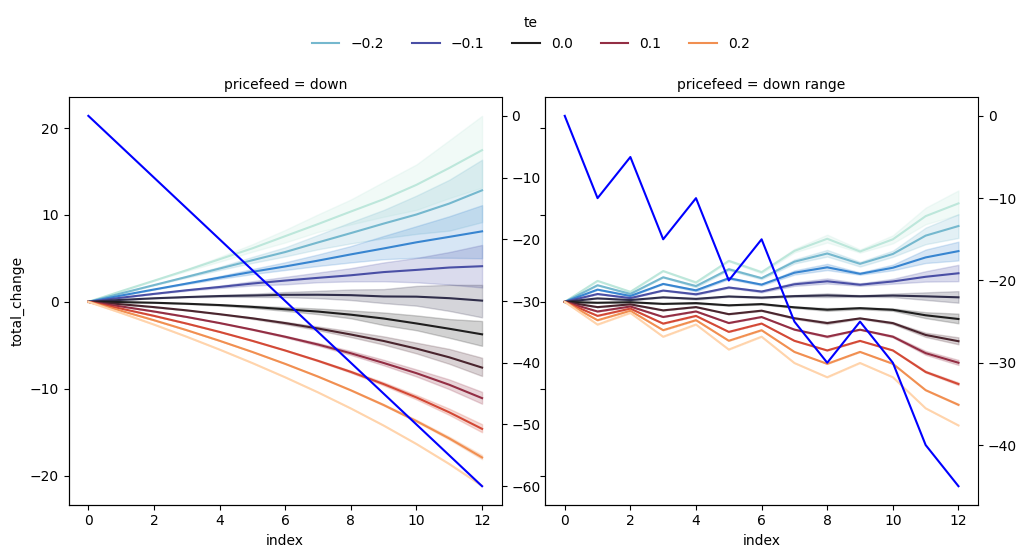

Plot below shows the total strategy returns vs target exposure


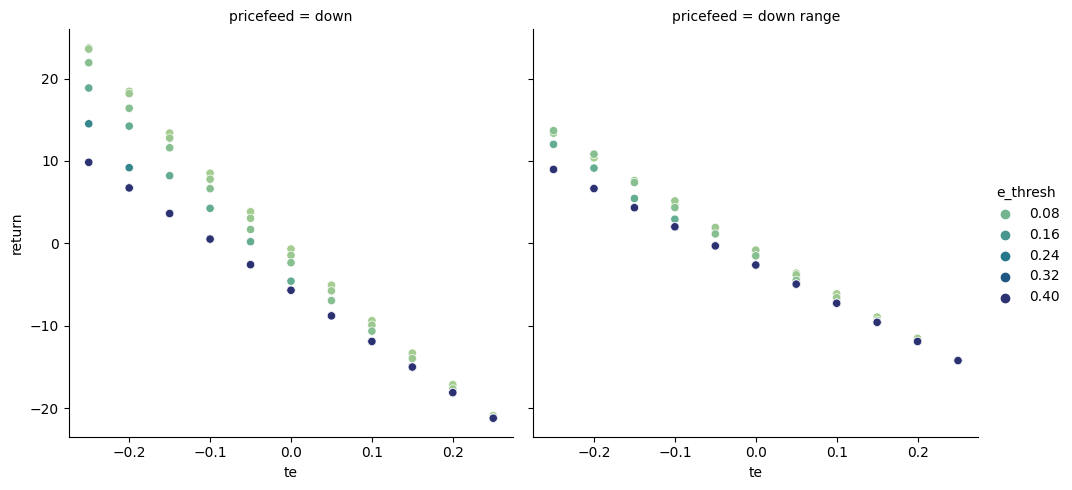

Plot below shows the total strategy returns vs exposure threshold
Blue band represents the range for all target exposures


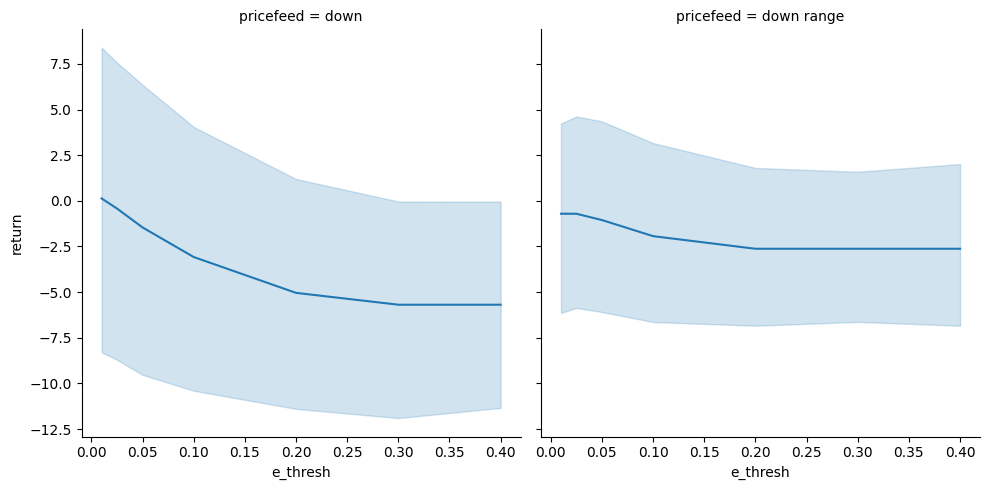

In [23]:
pricefeeds=['down','down range']
analyze_te(pricefeeds, df)

**Range Pricefeeds**

Key Points:
- Large e_thresh values perform better
- It seems that during ranging conditions the less you rebalance the better (makes sense given that price returns to similar levels)
- Interesting that the 0.1-0.2 is the worst performing e_thresh range

Pricefeed: range
----------------
Total Return for te: 0 and e_thresh 0.1 -> -14.1047%
Total Return for te: 0.05 and e_thresh 0.05 -> -8.0259%
Total Return for te: -0.05 and e_thresh 0.05 -> -9.3140%

Max Return -0.6490% -> te: 0.25 , e thresh: 0.1
Min Return -27.4148% -> te: -0.2 , e thresh: 0.2

Delta Neutral Returns

    e_thresh  return  exposure_rebal_count
35      0.01   -7.56                    12
36      0.02   -7.56                    12
37      0.05   -9.16                     5
38      0.10  -14.10                     2
39      0.20   -8.08                     0
40      0.30   -1.33                     0
41      0.40   -1.33                     0


Pricefeed: big range
----------------
Total Return for te: 0 and e_thresh 0.1 -> -11.8515%
Total Return for te: 0.05 and e_thresh 0.05 -> -5.7690%
Total Return for te: -0.05 and e_thresh 0.05 -> -9.9114%

Max Return -0.2558% -> te: 0.25 , e thresh: 0.05
Min Return -25.6291% -> te: -0.15 , e thresh: 0.2

Delta Neutral Returns

    

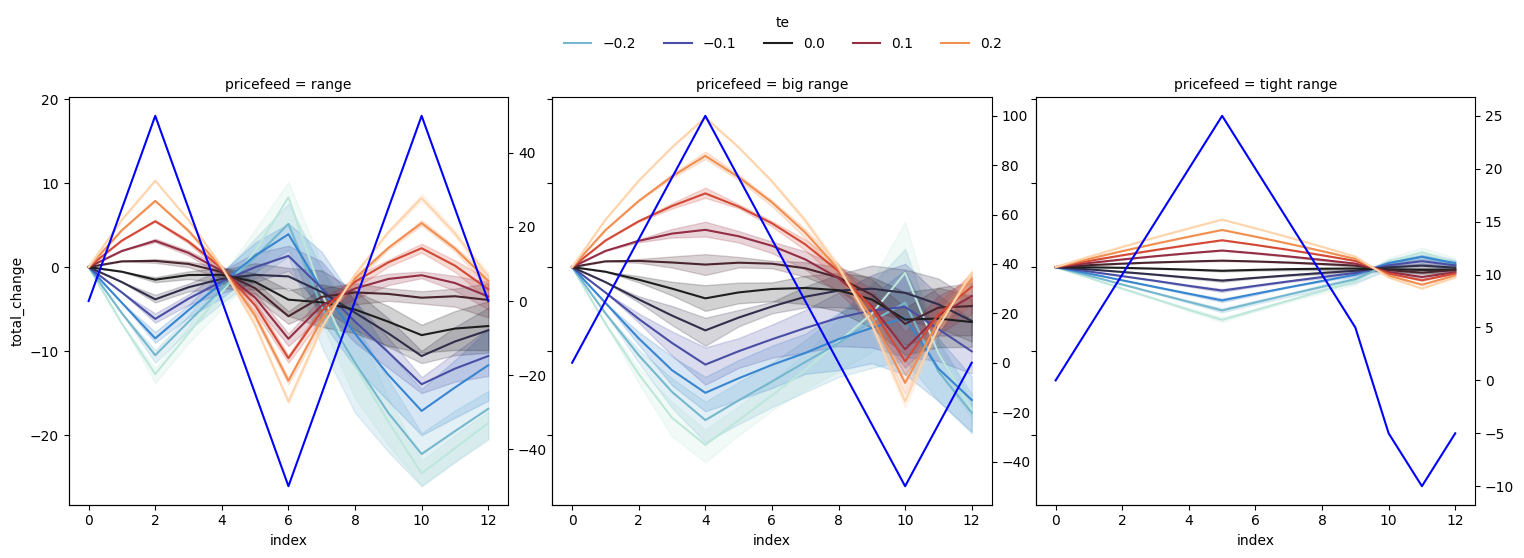

Plot below shows the total strategy returns vs target exposure


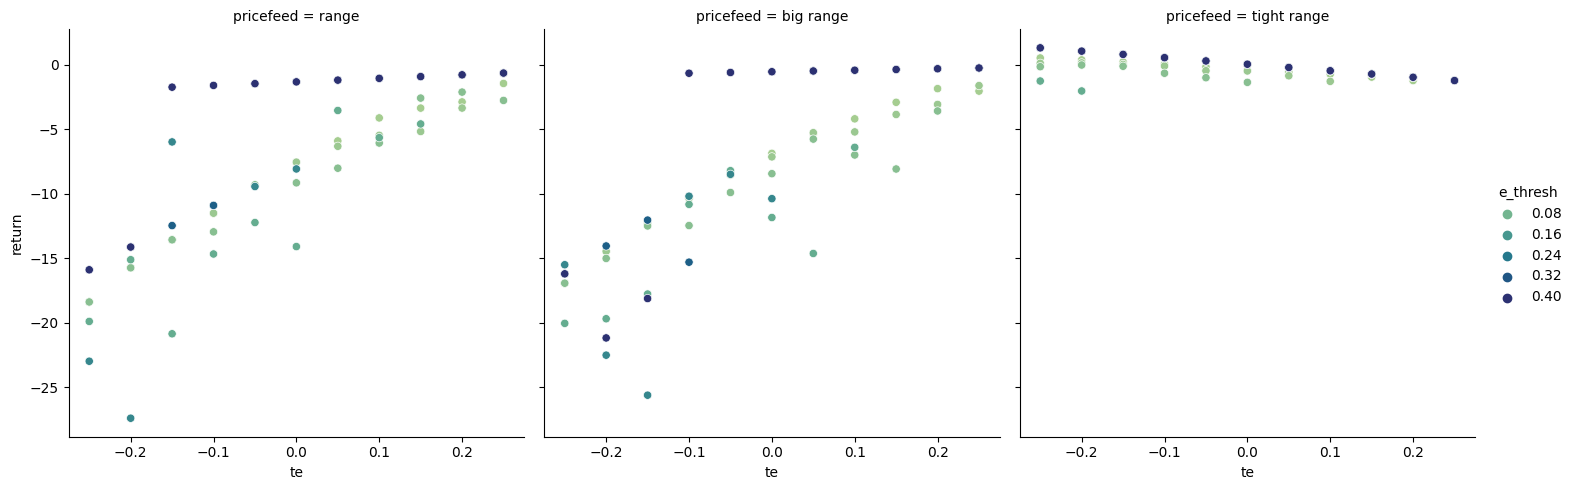

Plot below shows the total strategy returns vs exposure threshold
Blue band represents the range for all target exposures


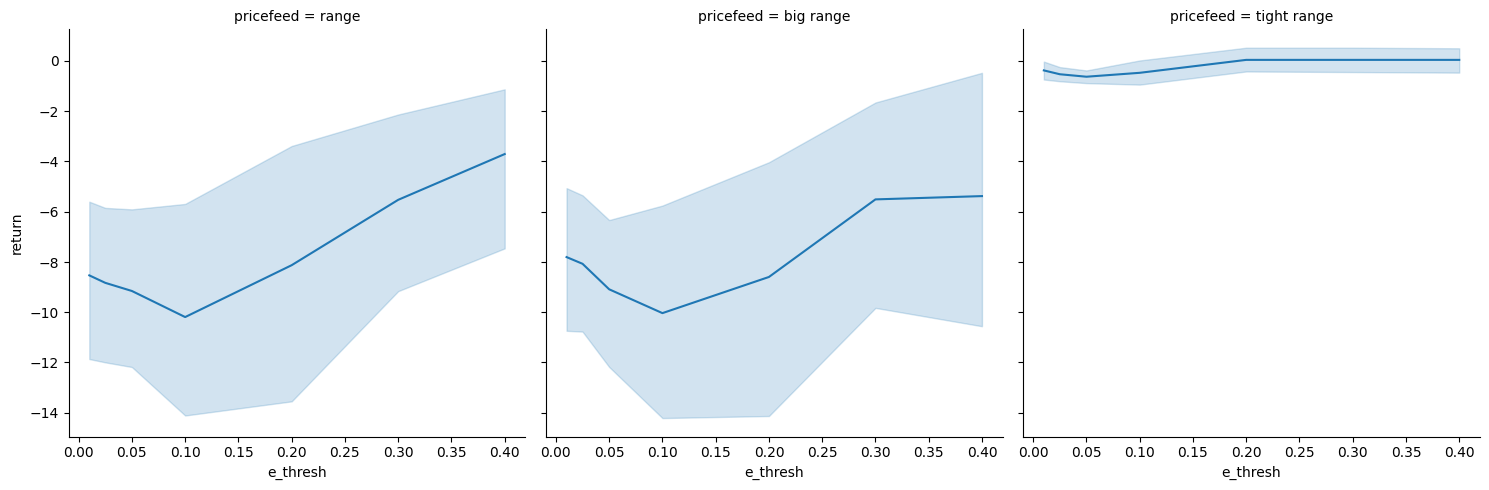

In [24]:
pricefeeds=['range','big range','tight range']
analyze_te(pricefeeds, df)

**Concave Up Pricefeeds**

Key Points:
- Strategy returns have less volatility (-10% to 10%)
- Best performing e_thresh is either vary low values, 0.01 or higher values > 0.2
- Also interesting to note that e_thresh values affect mostly lower target exposures

Pricefeed: concave up
----------------
Total Return for te: 0 and e_thresh 0.1 -> -0.3516%
Total Return for te: 0.05 and e_thresh 0.05 -> -0.3130%
Total Return for te: -0.05 and e_thresh 0.05 -> -1.3541%

Max Return -0.1587% -> te: 0.25 , e thresh: 0.01
Min Return -4.4976% -> te: -0.15 , e thresh: 0.1

Delta Neutral Returns

    e_thresh  return  exposure_rebal_count
35      0.01   -0.69                    10
36      0.02   -1.03                     4
37      0.05   -1.67                     2
38      0.10   -0.35                     0
39      0.20   -0.35                     0
40      0.30   -0.35                     0
41      0.40   -0.35                     0


Pricefeed: semi concave up
----------------
Total Return for te: 0 and e_thresh 0.1 -> -0.5073%
Total Return for te: 0.05 and e_thresh 0.05 -> -1.6147%
Total Return for te: -0.05 and e_thresh 0.05 -> 0.6181%

Max Return 5.5958% -> te: -0.25 , e thresh: 0.01
Min Return -6.0443% -> te: 0.25 , e thresh: 0.01

Delta Neutral Retur

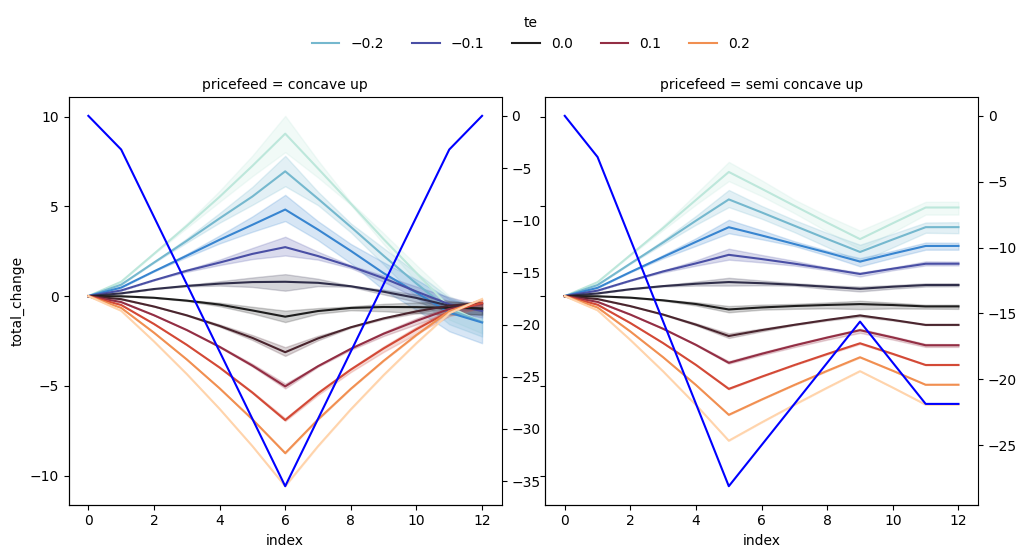

Plot below shows the total strategy returns vs target exposure


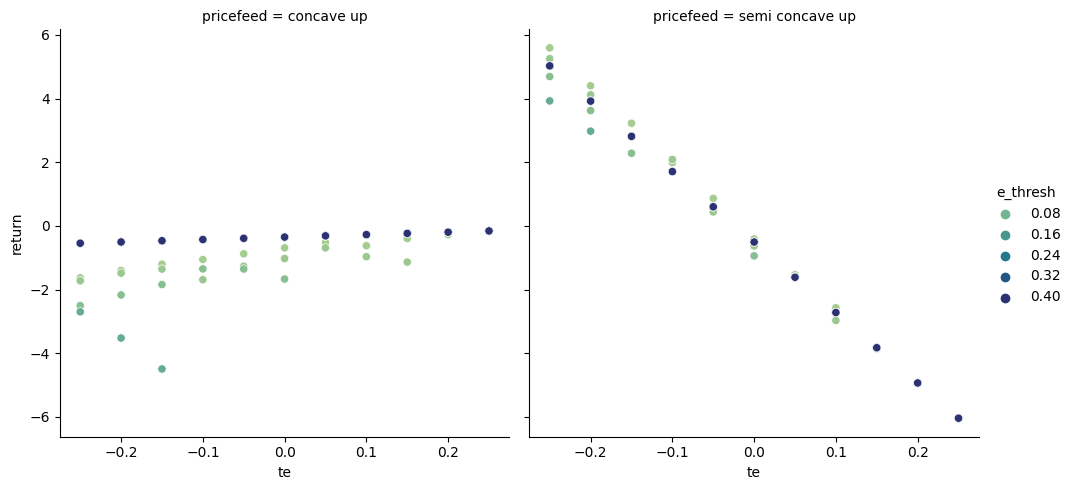

Plot below shows the total strategy returns vs exposure threshold
Blue band represents the range for all target exposures


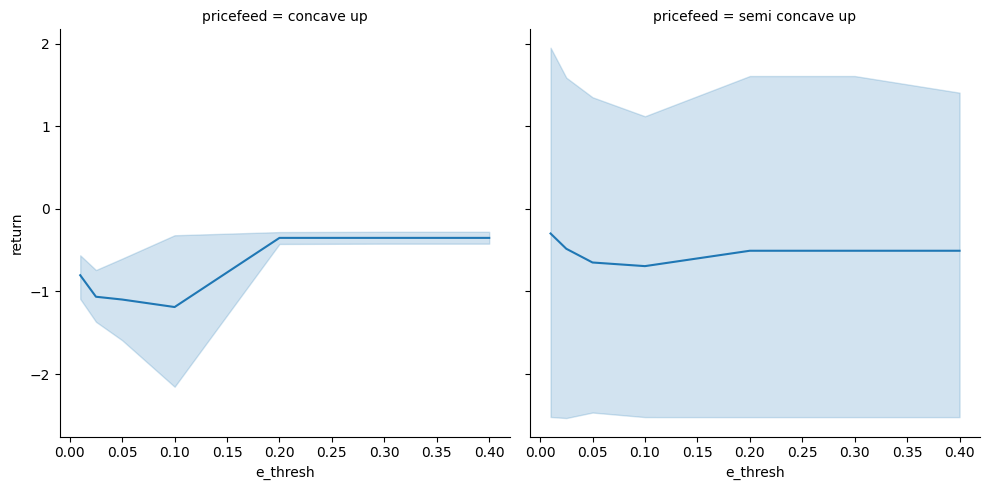

In [25]:
pricefeeds=['concave up','semi concave up']
analyze_te(pricefeeds, df)

**Concave Down Pricefeeds**

Key Points:
- Similar to concave up

Pricefeed: concave down
----------------
Total Return for te: 0 and e_thresh 0.1 -> -4.0393%
Total Return for te: 0.05 and e_thresh 0.05 -> -1.4275%
Total Return for te: -0.05 and e_thresh 0.05 -> -2.4923%

Max Return 0.2532% -> te: -0.25 , e thresh: 0.4
Min Return -10.0478% -> te: -0.25 , e thresh: 0.3

Delta Neutral Returns

    e_thresh  return  exposure_rebal_count
35      0.01   -0.68                    11
36      0.02   -1.42                     5
37      0.05   -1.01                     1
38      0.10   -4.04                     0
39      0.20    0.18                     0
40      0.30    0.18                     0
41      0.40    0.18                     0


Pricefeed: semi concave down
----------------
Total Return for te: 0 and e_thresh 0.1 -> -0.5136%
Total Return for te: 0.05 and e_thresh 0.05 -> 0.3040%
Total Return for te: -0.05 and e_thresh 0.05 -> -1.7688%

Max Return 5.6640% -> te: 0.25 , e thresh: 0.025
Min Return -9.7291% -> te: -0.25 , e thresh: 0.2

Delta Neutral R

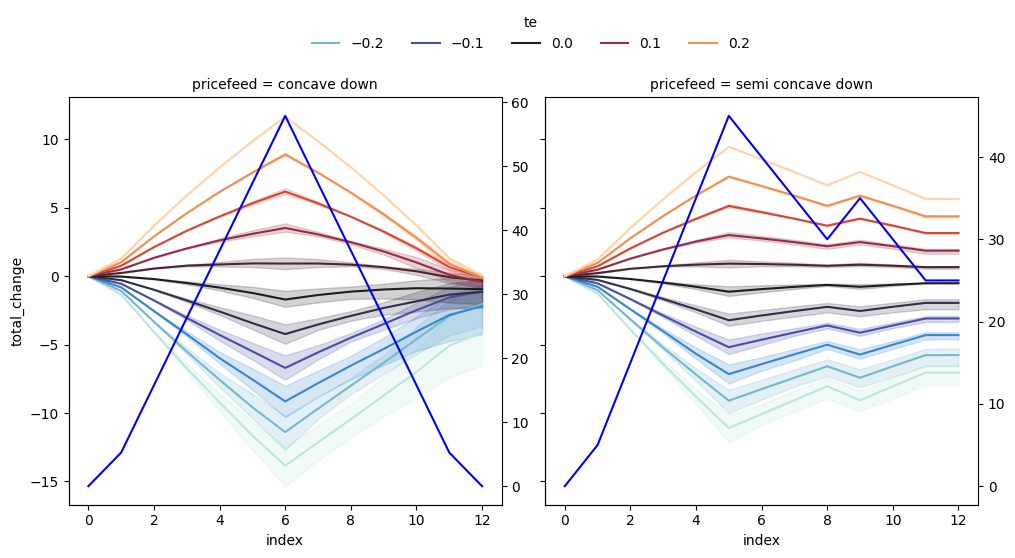

Plot below shows the total strategy returns vs target exposure


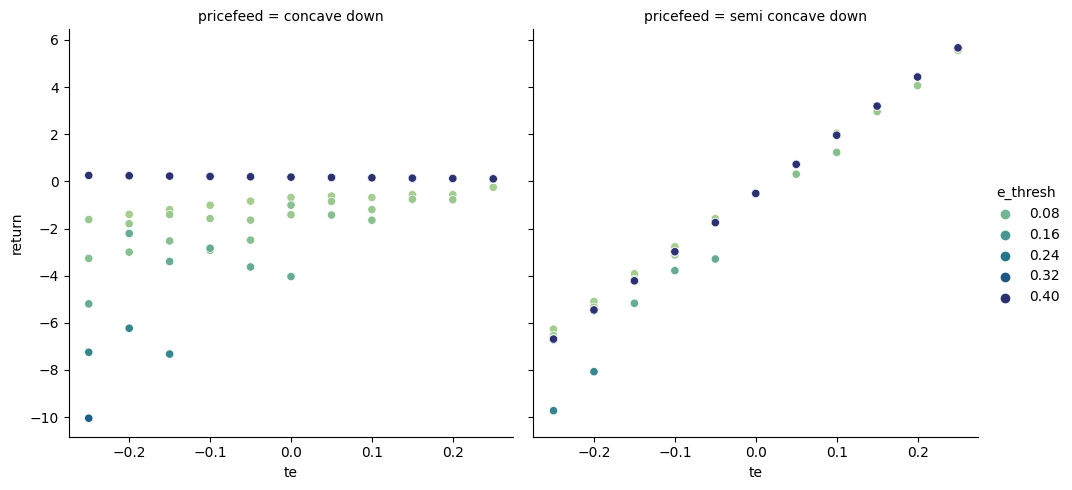

Plot below shows the total strategy returns vs exposure threshold
Blue band represents the range for all target exposures


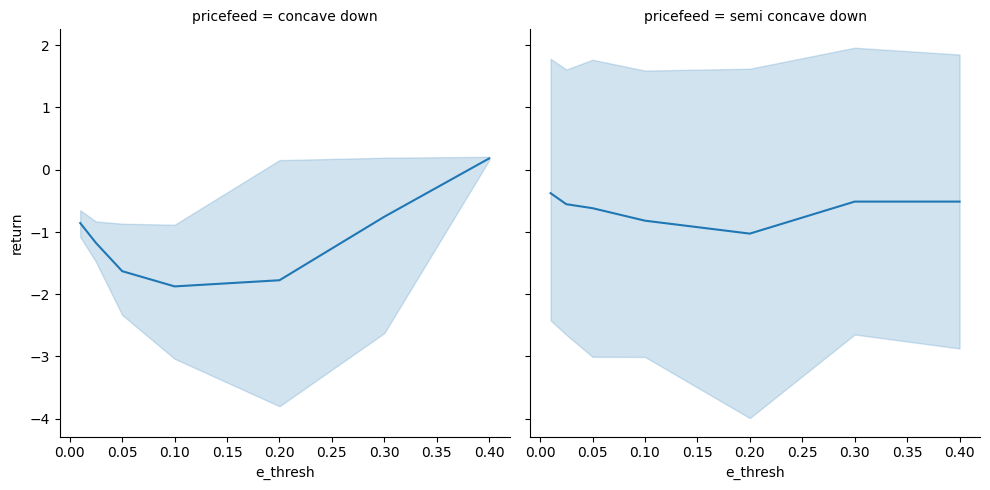

In [26]:
pricefeeds=['concave down','semi concave down']
analyze_te(pricefeeds, df)

**Big Concave Pricefeeds**

Pricefeed: big concave up
----------------
Total Return for te: 0 and e_thresh 0.1 -> -7.9373%
Total Return for te: 0.05 and e_thresh 0.05 -> -2.6653%
Total Return for te: -0.05 and e_thresh 0.05 -> -3.7261%

Max Return -0.1852% -> te: 0.25 , e thresh: 0.025
Min Return -16.3570% -> te: -0.25 , e thresh: 0.2

Delta Neutral Returns

    e_thresh  return  exposure_rebal_count
35      0.01   -2.09                    12
36      0.02   -2.77                     8
37      0.05   -4.67                     4
38      0.10   -7.94                     0
39      0.20   -0.40                     0
40      0.30   -0.40                     0
41      0.40   -0.40                     0


Pricefeed: big concave down
----------------
Total Return for te: 0 and e_thresh 0.1 -> -3.2040%
Total Return for te: 0.05 and e_thresh 0.05 -> -2.9791%
Total Return for te: -0.05 and e_thresh 0.05 -> -5.2208%

Max Return 1.1147% -> te: -0.05 , e thresh: 0.4
Min Return -19.7941% -> te: -0.2 , e thresh: 0.4

Delta Neutra

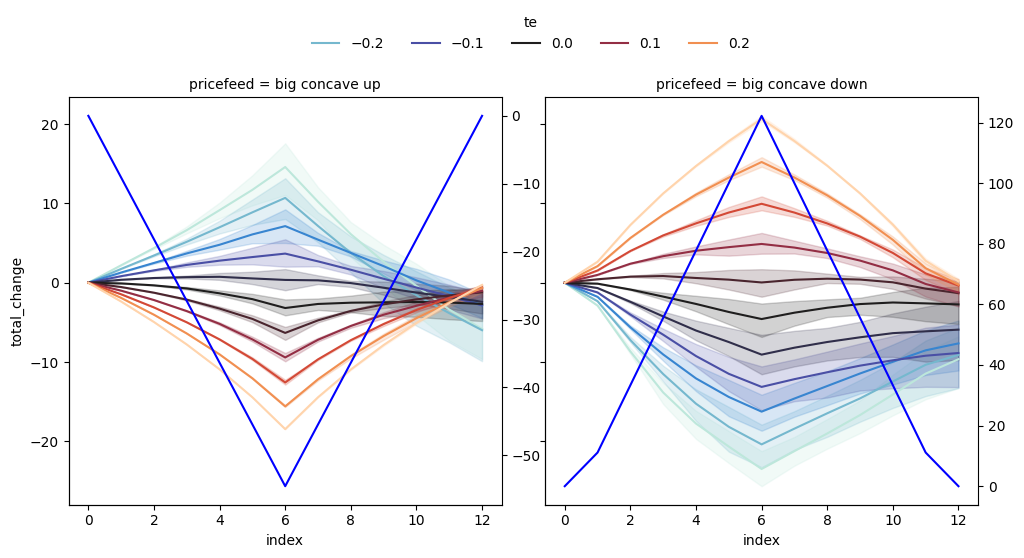

Plot below shows the total strategy returns vs target exposure


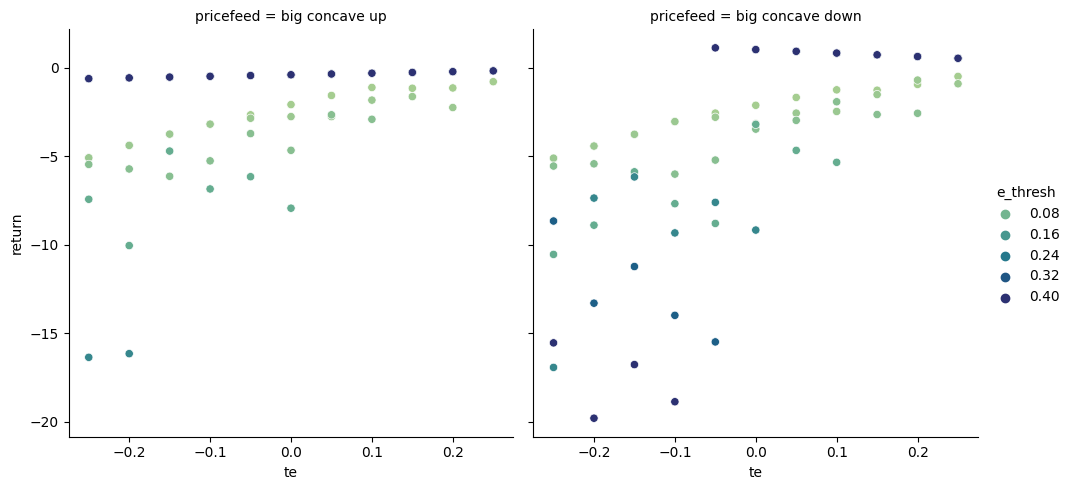

Plot below shows the total strategy returns vs exposure threshold
Blue band represents the range for all target exposures


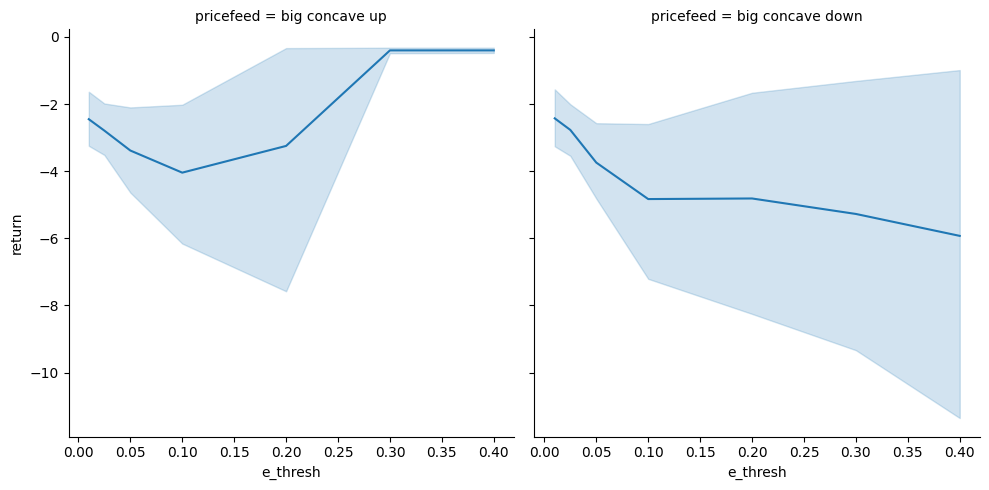

In [27]:
pricefeeds=['big concave up','big concave down']
analyze_te(pricefeeds, df)

### Updating Target Exposure

Up to this point, we have set an initial target exposure and haven't changed it during the whole simulation. <br>
One of the core benefits of this strategy is the ability to dynamically change the exposure depending on market conditions. 

In this section we will explore how the strategy performs when the target exposure changes throughout time.

#### Understanding the Operation

Updating the target exposure is a more complex operation. <br>
Main reason for this is the multiple initial states and final states the strategy can be at. <br>
The goal is to minimize the amount that needs to be swapped when updating the exposure. <br>

The logic is follows:
- First remove all liquidity from the AMM
- Second determine if collateral needs to be added
- Third determine if debt needs to be repaid
- Fourth determine if collateral needs to be removed
- Fifth determine if we need to borrow
- Last add all remaining assets to lp

Note that this operation brings the collateral ratio and exposure to their target levels

In [28]:
# Update exposure
def update_exposure(c: float, d: float, l: float, te: float, tcr: float, swapfee: float=0.0025):
    # Get new want state given target exposure
    _t = c - d + l
    _c, _d, _l = want_state(_t, tcr, te)
    
    # remove all liquidity
    _token1 = l/2
    _token2 = l/2
    
    # Check if collateral needs to be added
    _c_add = _c - c
    if _c_add > 0:
        if _token1 >= _c_add:
            _token1 -= _c_add
            c_fnl = c + _c_add
        else:
            _c_missing = _c_add - _token1
            _token2 -= _c_missing
            _token1 += _c_missing*(1-swapfee)
            c_fnl = c + _token1
            _token1 = 0
            
    # Check if debt must be repaid
    _d_repay = d - _d
    if _d_repay > 0:
        if _token2 >= _d_repay:
            _token2 -= _d_repay
            d_fnl = d - _d_repay
        else:
            _d_missing = _d_repay - _token2
            _token1 -= _d_missing
            _token2 += _d_missing*(1-swapfee)
            d_fnl = d - _token2
            _token2 = 0
            
    # Check if collateral needs to be removed
    _c_remove = c - _c
    if _c_remove > 0:
        c_fnl = c - _c_remove
        _token1 += _c_remove
        
    # Check if need to borrow
    _d_borrow = _d - d
    if _d_borrow > 0:
        d_fnl = d + _d_borrow
        _token2 += _d_borrow
        
    # Add remaining assets to liquidity pool
    if _token1 > _token2:
        _swap_qty = (_token1 - _token2)/2
        _token1 -= _swap_qty
        _token2 += _swap_qty*(1-swapfee)
    elif _token2 > _token1:
        _swap_qty = (_token2 - _token1)/2
        _token2 -= _swap_qty
        _token1 += _swap_qty*(1-swapfee)        
    l_fnl = _token1 + _token2
    
    return c_fnl, d_fnl, l_fnl, _c, _d, _l

# Given the initial state
te = -0.1
tcr = 0.65
c, d, l = want_state(10000, tcr, te)
cr, e = get_state(c, d, l)
print('Initial State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}'.format(cr, e, c-d+l))

# Now given a price change
rc, rd, rl, p_chg = 0.01/12, 0.03/12, 0.25/12, 0.1
c1, d1, l1 = update_all(c, d, l, rc, rd, rl, p_chg)
cr, e = get_state(c1, d1, l1)
print('\n')
print('New State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}'.format(cr, e, c1-d1+l1))

# Now, if we update the state
te = 0.1
c_fnl, d_fnl, l_fnl, _c, _d, _l =  update_exposure(c1, d1, l1, te, tcr)
cr, e = get_state(c_fnl, d_fnl, l_fnl)
print('\n')
print('Updated State\n---------------')
print('CR: {0:.3f}\nE: {1:.3f}\nTotal: ${2:.2f}'.format(cr, e, c_fnl-d_fnl+l_fnl))

Initial State
---------------
CR: 0.650
E: -0.100
Total: $10000.00


New State
---------------
CR: 0.716
E: -0.122
Total: $10047.06


Updated State
---------------
CR: 0.650
E: 0.100
Total: $10041.50


#### Updating Exposure = Trading?

Updating exposure can be think of as opening trading positions. <br>
For this reason, there is no correct way of doing this. <br>

For the purpose of this analysis we will show an extremely simple exposure updating strategy. <br>
We will update the target exposure once the price of FTM reaches specific price levels.

In [29]:
# Static Range
def static_range(pricefeed, price_ranges: dict[float, float], start_te: float):
    """
    price_ranges: must be a dict of the form {'Price Level': 'Target Exposure'}
    """
    te_feed = []
    curr_te = start_te
    p_last = pricefeed[0]
    
    for p in pricefeed:
        for k, v in price_ranges.items():
            if (p_last < k and p >= k) or (p_last > k and p <= k):
                period_te = v
                break
            else:
                period_te = curr_te
        te_feed.append(period_te)
        curr_te = period_te
        p_last = p
        
    return te_feed

# Set price ranges
test_feed = [1, 1.05, 1.03, 1.11, 1.04, 0.98, 0.95, 0.89, 0.99, 1.02, 1.12, 1.23]
price_ranges = {
    0.9: 0.1, 
    1: 0,
    1.1: 0.05,
    1.2: 0.1
}
t = static_range(test_feed, price_ranges, 0)

print('Function returns a list of target exposure')
print('List length is the same as the pricefeed which means that every datapoint corresponds to a pricefeed datapoint')
for p, t in zip(test_feed, t):
    print('${:.2f} -> {:.2f}'.format(p,t))

Function returns a list of target exposure
List length is the same as the pricefeed which means that every datapoint corresponds to a pricefeed datapoint
$1.00 -> 0.00
$1.05 -> 0.00
$1.03 -> 0.00
$1.11 -> 0.05
$1.04 -> 0.05
$0.98 -> 0.00
$0.95 -> 0.00
$0.89 -> 0.10
$0.99 -> 0.10
$1.02 -> 0.00
$1.12 -> 0.05
$1.23 -> 0.10


#### Simulating Strategy Returns Dynamically Updating Target Exposure

We'll first define the params that will remain constant for all sims. <br>
Then we will start with a simple sim.

In [30]:
# Params
t = 100
tcr = 0.65
c_apr = 0.01
d_apr = 0.03
l_apr = 0.25
min_per_step = 60
pricefeed = data['close'].tolist()
min_cr = 0.45
max_cr = 0.7

In [31]:
te = 0
e_thresh = 0.05
sim = SimulateStrat(t, tcr, te)

# Get update exposure list
price_ranges = {
    0.2: 0.1, 
    0.25: 0.05,
    0.3: 0,
    0.35: -0.05,
    0.4: -0.1
}
update_exposure_ls = static_range(pricefeed, price_ranges, 0)

# Run simulation
sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr, update_exposure_ls)

# Sim results
sim.print_sim_stats()


----------------------Strategy Total----------------------
Strategy Initial: $100.00
Strategy Final: $116.65
Strategy Max: $120.94
Strategy Min: $99.63

--------------------Strategy Timeframe--------------------
Total time in days: 303.2916666666667

--------------------Strategy Returns--------------------
Return: 16.645%
Total Return: $16.64508
Annualized Return: 20.032%
Max Daily Return: 2.126%
Min Daily Return: -2.986%
Max Weekly Return: 3.673%
Min Weekly Return: -5.687%

---------------------Strategy Params----------------------
Max Collateral Ratio: 0.77
Max Exposure: 0.12
Min Collateral Ratio: 0.45
Min Exposure: -0.16

---------------------Strategy Actions----------------------
Count of Collateral Rebalance: 30
Count of Exposure Rebalance: 7
Count of Both Rebalance: 2
Count of Exposure Update: 31


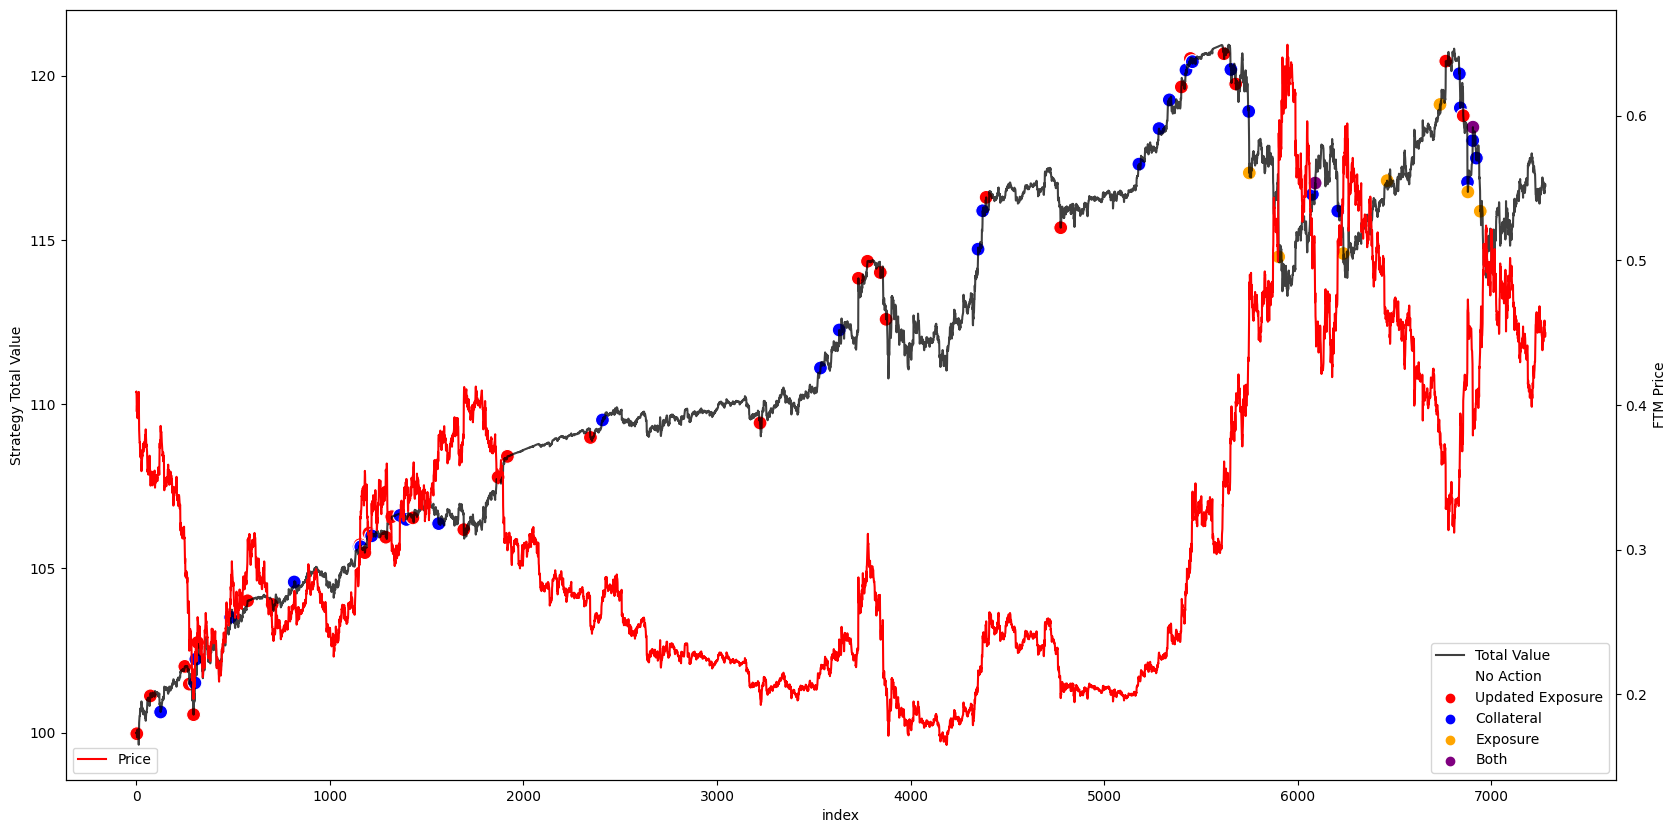

In [32]:
sim.plot_totals_with_rebalance_points()

Plot below shows the price of FTM and the target exposure <br>
Purple lines represent the price levels where exposure will be updated

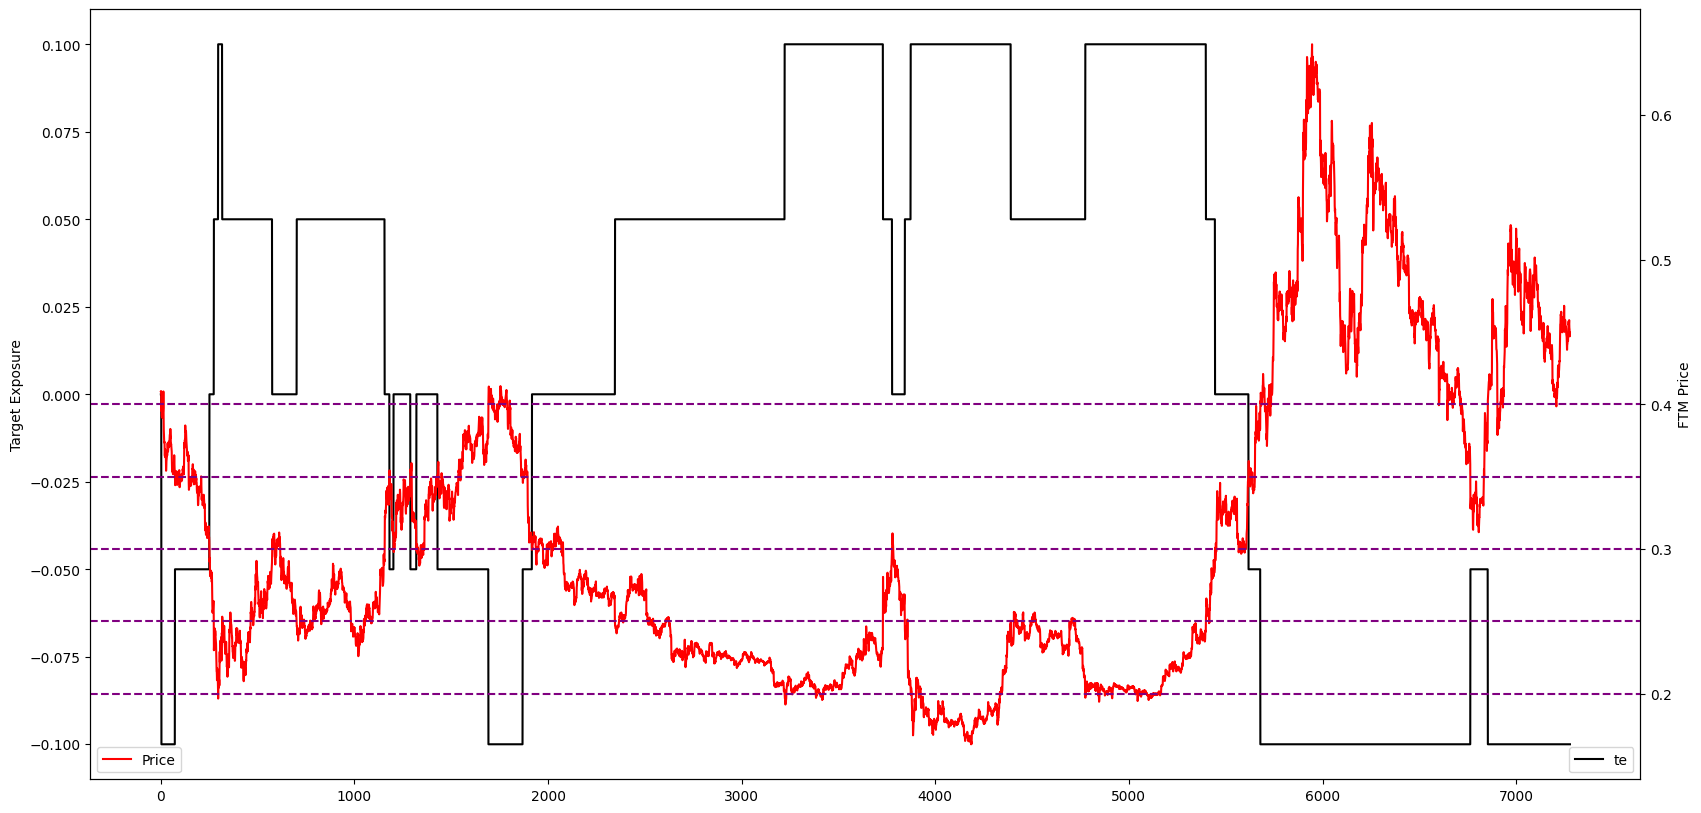

In [33]:
sim.plot_te_with_price_levels(price_ranges)

The sim above is meant to give us an idea of how the strategy performs when the target exposure is dynamically updated <br>
Below we will simulate 2 scenarios
- Conservative approach
- Riskier approach

**Conservative Approach**

The target exposure will always be between -0.05 and 0.05 <br>
We will simulate 2 scenarios:
- Having a good read of price levels
    - We will long at 0.2 and short and 0.5
- Having a poor read of price levels
    - We will never long

In [34]:
# Having a good read of price levels
te = 0
e_thresh = 0.05
sim = SimulateStrat(t, tcr, te)

price_ranges = {
    0.2: 0.05, 
    0.35: 0,
    0.5: -0.05
}
update_exposure_ls = static_range(pricefeed, price_ranges, 0)

# Run simulation
sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr, update_exposure_ls)

# Sim results
sim.print_sim_stats()


----------------------Strategy Total----------------------
Strategy Initial: $100.00
Strategy Final: $110.05
Strategy Max: $110.75
Strategy Min: $98.78

--------------------Strategy Timeframe--------------------
Total time in days: 303.2916666666667

--------------------Strategy Returns--------------------
Return: 10.047%
Total Return: $10.04736
Annualized Return: 12.092%
Max Daily Return: 0.973%
Min Daily Return: -2.186%
Max Weekly Return: 2.074%
Min Weekly Return: -3.234%

---------------------Strategy Params----------------------
Max Collateral Ratio: 0.77
Max Exposure: 0.10
Min Collateral Ratio: 0.44
Min Exposure: -0.10

---------------------Strategy Actions----------------------
Count of Collateral Rebalance: 38
Count of Exposure Rebalance: 11
Count of Both Rebalance: 4
Count of Exposure Update: 7


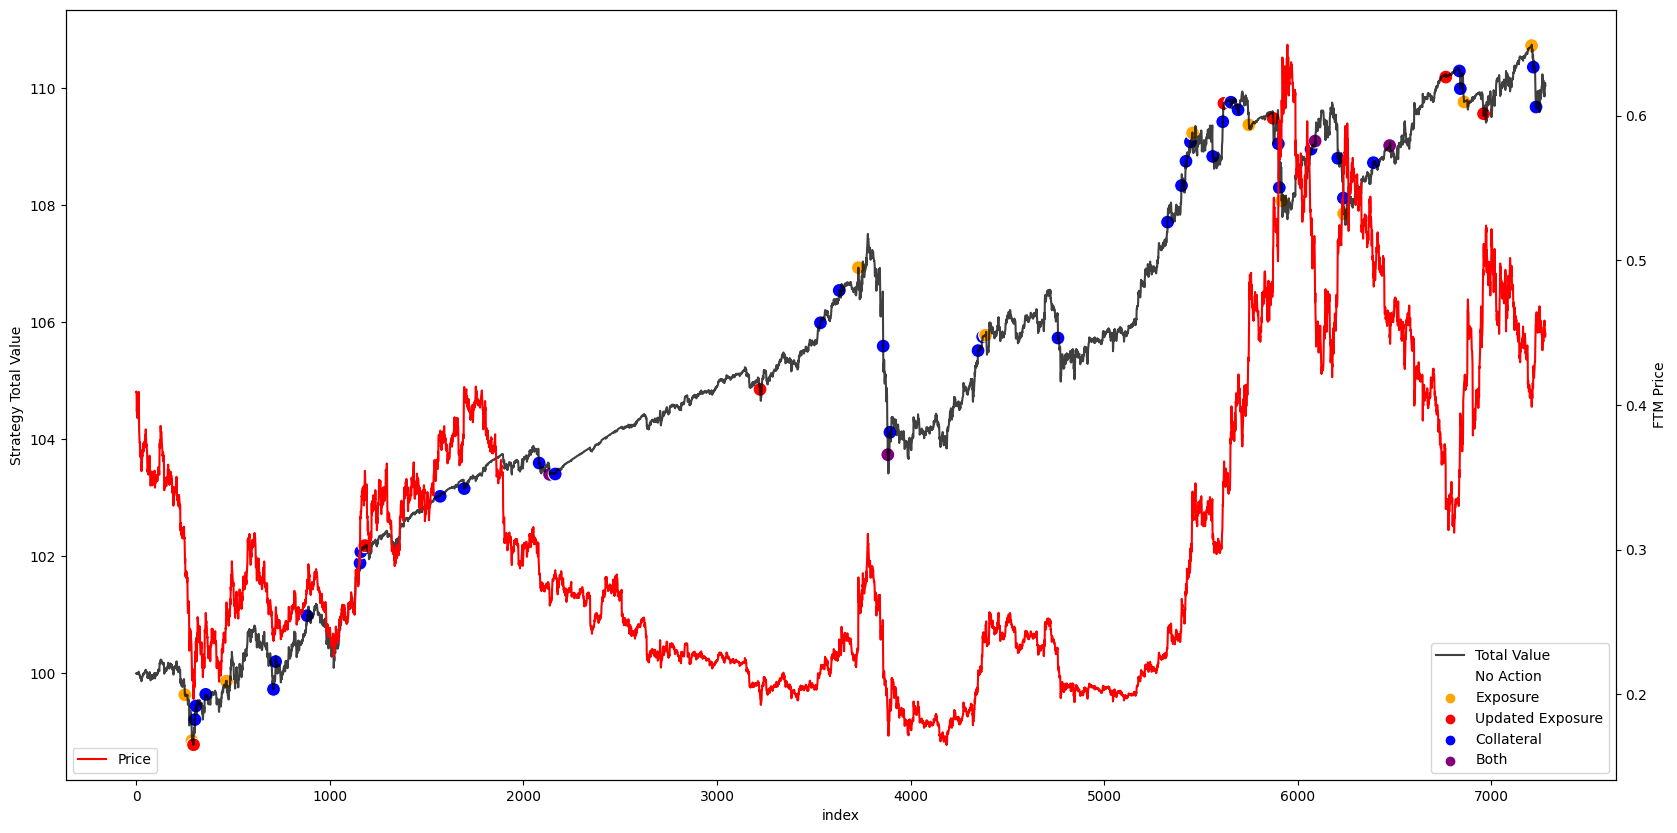

In [35]:
sim.plot_totals_with_rebalance_points()

In [36]:
# Having a poor read of price levels
te = 0
e_thresh = 0.05
sim = SimulateStrat(t, tcr, te)

price_ranges = {
    0.2: 0, 
    0.3: -0.025,
    0.4: -0.05
}
update_exposure_ls = static_range(pricefeed, price_ranges, 0)

# Run simulation
sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr, update_exposure_ls)

# Sim results
sim.print_sim_stats()


----------------------Strategy Total----------------------
Strategy Initial: $100.00
Strategy Final: $104.03
Strategy Max: $107.65
Strategy Min: $99.82

--------------------Strategy Timeframe--------------------
Total time in days: 303.2916666666667

--------------------Strategy Returns--------------------
Return: 4.032%
Total Return: $4.03200
Annualized Return: 4.852%
Max Daily Return: 1.259%
Min Daily Return: -1.735%
Max Weekly Return: 1.609%
Min Weekly Return: -3.196%

---------------------Strategy Params----------------------
Max Collateral Ratio: 0.77
Max Exposure: 0.05
Min Collateral Ratio: 0.44
Min Exposure: -0.11

---------------------Strategy Actions----------------------
Count of Collateral Rebalance: 34
Count of Exposure Rebalance: 18
Count of Both Rebalance: 2
Count of Exposure Update: 11


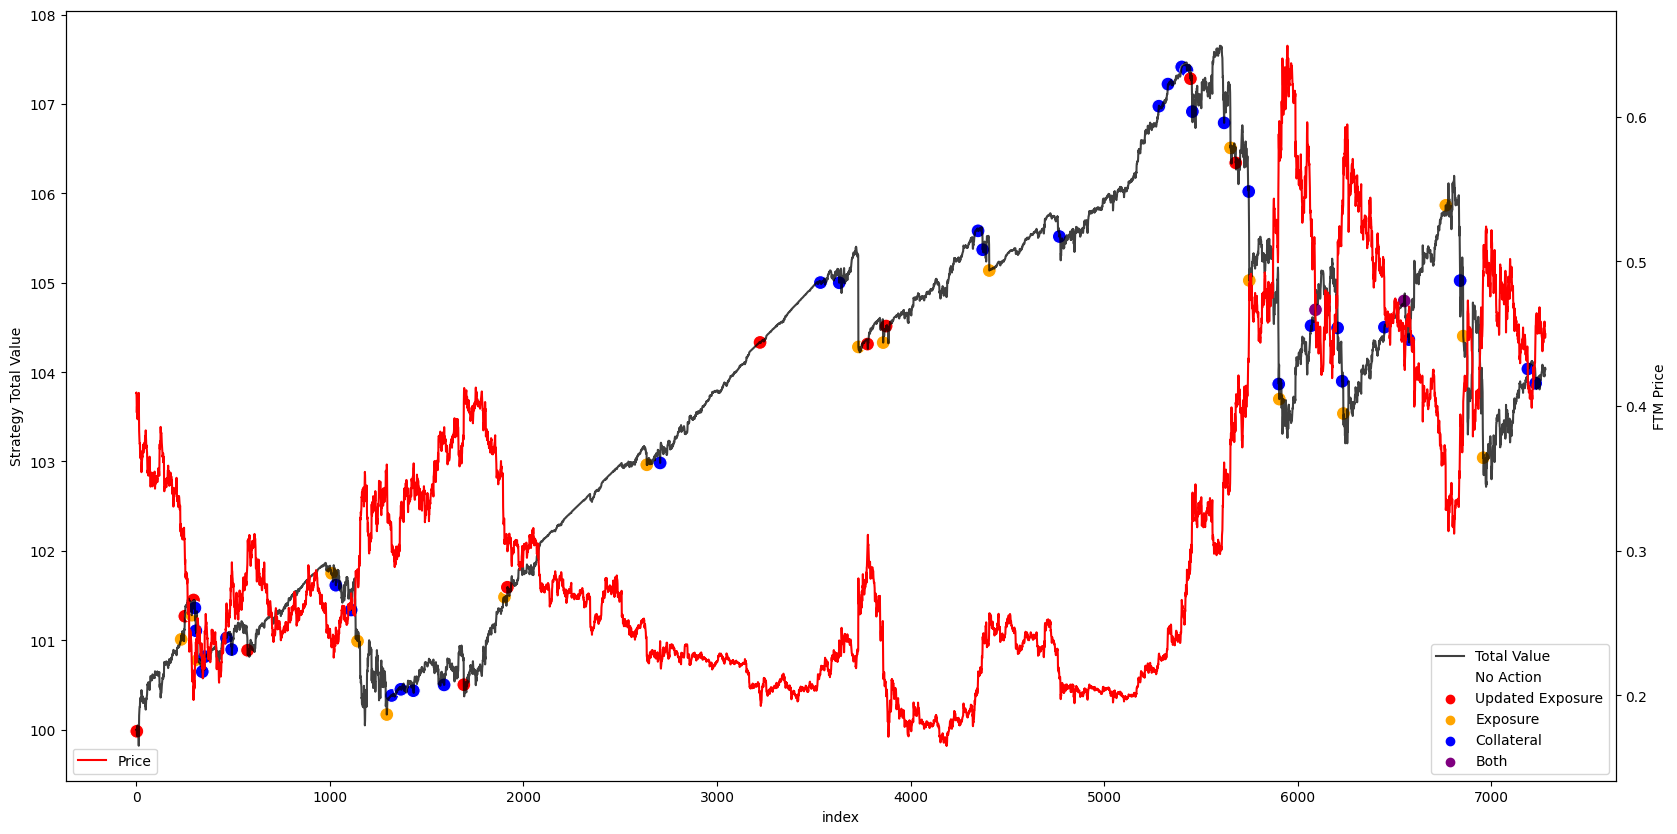

In [37]:
sim.plot_totals_with_rebalance_points()

Takeaways:
- When keeping the target exposure between -0.05 and 0.05 the max weekly drawdown is close to 3.1%
- Even when having a poor read, the strategy still performs well
- Even with FTM going from 0.2 to 0.6 and the strategy being short, the drawdown is relatively controlled
    - With the max drawdown being from approx 108 to 103 (a 4.5% drop)

**Riskier Approach**

The target exposure will be between -0.1 and 0.2 <br>
We will simulate 2 scenarios:
- Having a good read of price levels
    - We will long at 0.2 and short and 0.5
- Having a poor read of price levels
    - We will never long

In [38]:
# Having a good read of price levels
te = 0
e_thresh = 0.05
sim = SimulateStrat(t, tcr, te)

price_ranges = {
    0.2: 0.2, 
    0.3: 0.1,
    0.4: 0,
    0.5: -0.1
}

update_exposure_ls = static_range(pricefeed, price_ranges, 0)

# Run simulation
sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr, update_exposure_ls)

# Sim results
sim.print_sim_stats()


----------------------Strategy Total----------------------
Strategy Initial: $100.00
Strategy Final: $133.50
Strategy Max: $133.53
Strategy Min: $94.86

--------------------Strategy Timeframe--------------------
Total time in days: 303.2916666666667

--------------------Strategy Returns--------------------
Return: 33.495%
Total Return: $33.49536
Annualized Return: 40.310%
Max Daily Return: 4.612%
Min Daily Return: -3.978%
Max Weekly Return: 7.374%
Min Weekly Return: -6.281%

---------------------Strategy Params----------------------
Max Collateral Ratio: 0.77
Max Exposure: 0.21
Min Collateral Ratio: 0.44
Min Exposure: -0.15

---------------------Strategy Actions----------------------
Count of Collateral Rebalance: 25
Count of Exposure Rebalance: 5
Count of Both Rebalance: 0
Count of Exposure Update: 14


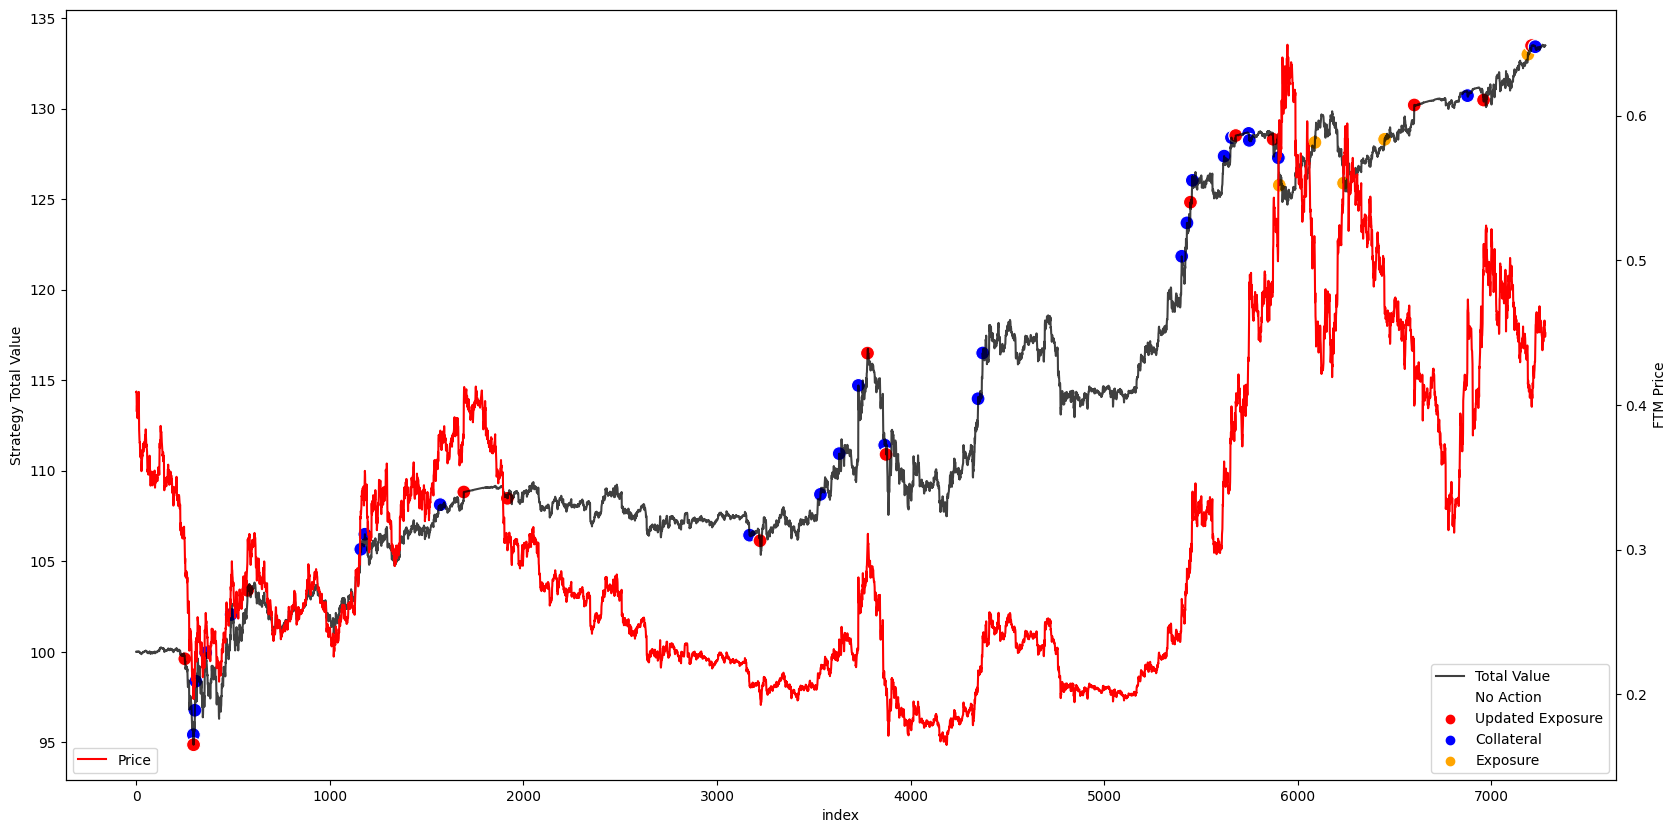

In [39]:
sim.plot_totals_with_rebalance_points()

In [40]:
# Having a poor read of price levels
te = 0
e_thresh = 0.05
sim = SimulateStrat(t, tcr, te)

price_ranges = {
    0.2: 0, 
    0.3: -0.05,
    0.4: -0.1
}

update_exposure_ls = static_range(pricefeed, price_ranges, 0)

# Run simulation
sim.run(pricefeed, c_apr, d_apr, l_apr, min_per_step, max_cr, e_thresh, min_cr, update_exposure_ls)

# Sim results
sim.print_sim_stats()


----------------------Strategy Total----------------------
Strategy Initial: $100.00
Strategy Final: $108.73
Strategy Max: $113.47
Strategy Min: $99.63

--------------------Strategy Timeframe--------------------
Total time in days: 303.2916666666667

--------------------Strategy Returns--------------------
Return: 8.726%
Total Return: $8.72594
Annualized Return: 10.501%
Max Daily Return: 1.572%
Min Daily Return: -2.986%
Max Weekly Return: 3.673%
Min Weekly Return: -5.398%

---------------------Strategy Params----------------------
Max Collateral Ratio: 0.77
Max Exposure: 0.05
Min Collateral Ratio: 0.43
Min Exposure: -0.17

---------------------Strategy Actions----------------------
Count of Collateral Rebalance: 34
Count of Exposure Rebalance: 18
Count of Both Rebalance: 1
Count of Exposure Update: 11


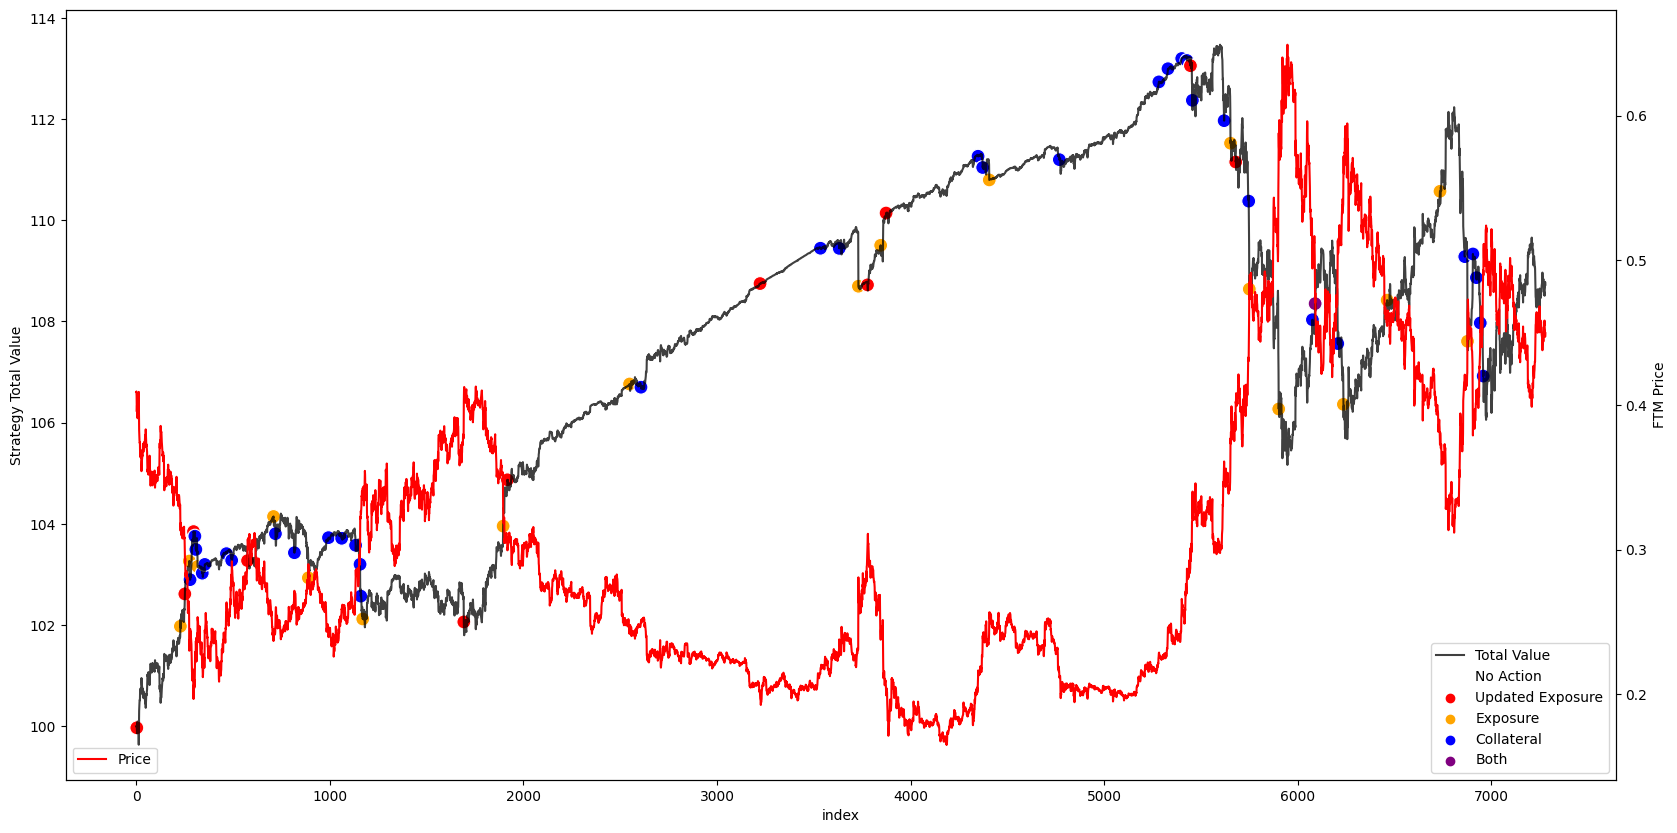

In [41]:
sim.plot_totals_with_rebalance_points()

Takeaways:
- With higher target exposure volatility increases (weekly drawdowns can get to -6.5%)
- Even when having a poor read, the strategy still performs well
- Even with FTM going from 0.2 to 0.6 and the strategy being short, the drawdown is relatively controlled
    - With the max drawdown being from approx 113 to 105 (a 7% drop)
- Finally, having a good read of the market can solid returns with minimal drawdowns
    - As it can be seen in the first simulation, the total return with very simple rules is 33%

### Last Thoughts

- Updating the target exposure is key to having a profitable strategy. The simulations above are meant only to give an idea of how the strategy behaves. 
- Providing liquidity to an AMM gives significant drawdown protection during long term periods
- Using the target exposure, we can control the risk of our position
- Simulations above do not consider dynamically updating the exposure threshold as well (this also provides more detailed control over risk/returns)

## Withdrawal Analysis

The code below is used to determine the optimal way to create the withdrawal function

NOTE: couldn't implement first function due to max code size constraints.

In [16]:
def withdraw(c, d, l, w, te, ethresh, mincr, maxcr, swapfee=0.0025, log=False):
    # Check if withdrawing from lp keeps te and cr within valid range
    _l = l - w
    _d = d - w/2
    _c = c - w/2
    _cr = _d/_c
    _e = (_l*0.5 - _d)/(_c-_d+_l)
    
    if w > l:
        if log == True:
            print('w > l', _cr, _e)
        withdraw_type = 'none'
        _w = w
    
    elif abs(te - _e) < ethresh and mincr < _cr and maxcr > _cr:
        withdraw_type = 'simple'
        if log == True:
            print('simple', _cr, _e)
        _w = w
    
    else:
        withdraw_type = 'percentage'
        if log == True:
            print('perc', _cr, _e)
        perc_w = w/(c-d+l)
        
        # Withdraw from lp
        _lp_remove = l*perc_w
        _l = l - _lp_remove
        
        # Repay debt
        _repay_amt = d*perc_w
        _var_bal = _lp_remove/2
        _stable_bal = _lp_remove/2
        if _repay_amt > _var_bal:
            _swap_amt = (_repay_amt - _var_bal)
            _var_bal += _swap_amt*(1-swapfee)
            _stable_bal -= _swap_amt
            _d = d - _var_bal
            _var_bal = 0
        else:
            _d = d - _repay_amt
            _var_bal -= _repay_amt
            
        # Remove collateral
        _remove_amt = c*perc_w
        _c = c - _remove_amt
        _stable_bal += _remove_amt
        if _var_bal > 0:
            _stable_bal += _var_bal*(1-swapfee)
            _var_bal = 0
        _w = _stable_bal
        
    if log == True:
        return _c, _d, _l, _w, withdraw_type
    else:
        return withdraw_type    

In [103]:
def withdraw2(c, d, l, w, tcr, te, ethresh, mincr, maxcr, swapfee=0.0025, log=False):
    # Check if withdrawing from lp keeps te and cr within valid range
    l0 = l - w
    d0 = d - w/2
    c0 = c - w/2
    cr0 = d0/c0
    e0 = (l0*0.5 - d0)/(c0-d0+l0)
    
    if w > l:
        if log == True:
            print('w > l', cr0, e0)
        withdraw_type = 'none'
        _w = w
    
    else:
        if abs(te - e0) > ethresh:
            a, c1, d1, l1 = exposure_rebal(c, d, l, te, swapfee)
            withdraw_type = 'e'
            cr_e, e_e = get_state(c1, d1, l1)
            if cr_e > tcr+0.02:
                a, c1, d1, l1 = cr_rebal(c1, d1, l1, tcr)
        elif mincr > cr0 or maxcr < cr0:
            a, c1, d1, l1 = cr_rebal(c, d, l, tcr)
            withdraw_type = 'cr'
        else:
            withdraw_type = 'normal'
            c1 = c
            d1 = d
            l1 = l
        
        _l = l1 - w
        _d = d1 - w/2
        _c = c1 - w/2
        _cr = _d/_c
        _e = (_l*0.5 - _d)/(_c-_d+_l)
        _w = w
        
        if log == True:
            print(withdraw_type, _cr, _e)
        
    if log == True:
        return _c, _d, _l, _w, withdraw_type
    else:
        return withdraw_type, _cr, _e 

In [104]:
df = sim.simdf.copy()

w = 10
ethresh = 0.05
mincr = 0.45
maxcr = 0.7
a = df.apply(lambda row: withdraw2(row['Collateral'], row['Debt'], row['LP'], w, tcr, 
                                   row['Target Exposure'], ethresh, mincr, maxcr), axis=1)

In [106]:
row = df.iloc[277]
c, d, l, w, withdraw_type = withdraw2(row['Collateral'], row['Debt'], row['LP'], w, tcr,
                                     row['Target Exposure'], row['Target Exposure'], ethresh, 
                                     mincr, maxcr, log=True)
print(w)

normal 0.447982610110196 0.1390765022495961
10


In [111]:
d = [i[0] for i in a]
df['w_cr'] = [i[1] for i in a]
df['w_e'] = [i[2] for i in a]
df['w_ediff'] = np.abs(df['Target Exposure'] - df['w_e'])

d = df.loc[(df['w_type']=='normal')]# & (df['w_cr'] > 0.8)]
d

index  Collateral       Debt          LP       Total        CR   
0         0   60.606061  39.393939   78.787879  100.000000  0.650000  \
1         1   60.606130  39.422970   78.819018  100.002178  0.650478   
2         2   60.606199  39.124518   78.522208  100.003889  0.645553   
3         3   60.606268  38.084410   77.473516   99.995375  0.628391   
4         4   60.606337  38.498712   77.895865  100.003490  0.635226   
...     ...         ...        ...         ...         ...       ...   
7274   7274   84.018404  57.097184  106.494244  133.415464  0.679579   
7275   7275   84.018500  56.449537  105.891385  133.460349  0.671870   
7276   7276   84.018596  56.287769  105.742386  133.473213  0.669944   
7277   7277   84.018692  55.702407  105.193940  133.510225  0.662976   
7278   7278   84.018788  56.014064  105.490641  133.495365  0.666685   

          Exposure  Updated CR  Updated Exposure     Action   Price   
0    -7.105427e-17    0.650000     -7.105427e-17  No Action  0.4090  \
1    -1.346035e-04    0.650478     -1.346035e-04  No Action  0.4093   
2     1.365807e-03    0.645553      1.365807e-03  No Action  0.4062   
3     6.523785e-03    0.628391      6.523785e-03  No Action  0.3954   
4     4.492047e-03    0.635226      4.492047e-03  No Action  0.3997   
...            ...         ...               ...        ...     ...   
7274 -2.885769e-02    0.679579     -2.885769e-02  No Action  0.4583   
7275 -2.625382e-02    0.671870     -2.625382e-02  No Action  0.4531   
7276 -2.559746e-02    0.669944     -2.559746e-02  No Action  0.4518   
7277 -2.325992e-02    0.662976     -2.325992e-02  No Action  0.4471   
7278 -2.448582e-02    0.666685     -2.448582e-02  No Action  0.4496   

      Price Change  Target Exposure  daily_return  weekly_return  rebal_plot   
0         0.000000              0.0           NaN            NaN         NaN  \
1         0.000733              0.0           NaN            NaN         NaN   
2        -0.007574              0.0           NaN            NaN         NaN   
3        -0.026588              0.0           NaN            NaN         NaN   
4         0.010875              0.0           NaN            NaN         NaN   
...            ...              ...           ...            ...         ...   
7274      0.005044              0.0      0.000235       0.015002         NaN   
7275     -0.011346              0.0      0.000503       0.014741         NaN   
7276     -0.002869              0.0      0.000537       0.014557         NaN   
7277     -0.010403              0.0      0.001186       0.014853         NaN   
7278      0.005592              0.0      0.000958       0.014911         NaN   

      w_type      w_cr           w_e       w_ediff  
0     normal  0.618529 -7.894919e-17  7.894919e-17  
1     normal  0.619050 -1.495591e-04  1.495591e-04  
2     normal  0.613682  1.517557e-03  1.517557e-03  
3     normal  0.594976  7.248687e-03  7.248687e-03  
4     normal  0.602426  4.991144e-03  4.991144e-03  
...      ...       ...           ...           ...  
7274  normal  0.659304 -3.119595e-02  3.119595e-02  
7275  normal  0.651107 -2.838032e-02  2.838032e-02  
7276  normal  0.649059 -2.767058e-02  2.767058e-02  
7277  normal  0.641651 -2.514316e-02  2.514316e-02  
7278  normal  0.645594 -2.646855e-02  2.646855e-02  

[6693 rows x 20 columns]

In [113]:
df['w_type'].value_counts()

w_type
normal    6693
cr         405
e          181
Name: count, dtype: int64

In [112]:
#df['LP'].min()
d.describe()

index   Collateral         Debt           LP        Total   
count  6693.000000  6693.000000  6693.000000  6693.000000  6693.000000  \
mean   3710.043030    58.553415    35.140541    90.709393   114.122267   
std    2165.957447    19.265259    11.352087     8.188467    10.250311   
min       0.000000    34.501689    20.337507    69.553484    94.864767   
25%    1709.000000    43.584081    26.404481    84.387685   107.163832   
50%    3925.000000    52.619174    30.722752    90.976582   109.961563   
75%    5598.000000    65.976658    42.319523    96.358446   125.709265   
max    7278.000000    96.337039    65.075002   109.165427   133.528762   

                CR     Exposure   Updated CR  Updated Exposure        Price   
count  6693.000000  6693.000000  6693.000000       6693.000000  6693.000000  \
mean      0.603180     0.094980     0.603089          0.094967     0.312267   
std       0.049109     0.100937     0.048492          0.100951     0.105986   
min       0.440109    -0.153735     0.478786         -0.133023     0.165100   
25%       0.561205     0.016101     0.561366          0.016024     0.232400   
50%       0.603359     0.113041     0.603500          0.113010     0.275000   
75%       0.644485     0.194519     0.644649          0.194548     0.379700   
max       0.767387     0.211169     0.699802          0.211169     0.649000   

       Price Change  Target Exposure  daily_return  weekly_return  rebal_plot   
count   6693.000000      6693.000000   6669.000000    6525.000000   43.000000  \
mean       0.000222         0.090931      0.001248       0.007824  116.983638   
std        0.012649         0.104472      0.007518       0.021146   12.250998   
min       -0.091839        -0.100000     -0.039778      -0.062812   94.864767   
25%       -0.005612         0.000000     -0.002113      -0.003862  107.306854   
50%        0.000000         0.100000      0.000688       0.005562  116.500952   
75%        0.005804         0.200000      0.004369       0.016686  128.274609   
max        0.215058         0.200000      0.046117       0.073741  133.480729   

              w_cr          w_e       w_ediff  
count  6693.000000  6693.000000  6.693000e+03  
mean      0.562101     0.104699  1.853896e-02  
std       0.052273     0.110615  1.125748e-02  
min       0.450040    -0.144409  7.894919e-17  
25%       0.520301     0.017687  8.978021e-03  
50%       0.563960     0.124675  1.912377e-02  
75%       0.606287     0.213644  2.646534e-02  
max       0.680030     0.232831  4.983426e-02